# Exercises Week 11-12: Graded exercise session (part B)

**Course**: [Life Sciences engineering: genome to function](https://go.epfl.ch/BIO-411) (BIO-411)

**Professors**:  _Gönczy Pierre_, _Naef Felix_, _McCabe Brian Donal_

SSV, MA, 2023-2024

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale

from scipy.integrate import odeint
import gseapy as gp
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
from scipy.stats import beta
import seaborn as sns
import math

**Provide answers in the form of code, figures (if relevant) and short descriptions (in markdown cells) in those notebooks. Submit your notebook to Moodle, please make sure to execute every cell.**

## Exercise 1: Simulation of circadian gene regulation

In this exercise, we revisit and extend the concepts from Week 9, focusing on the transcription and splicing of a pre-mRNA to produce mRNA. We describe this process using a two-dimensional Ordinary Differential Equation (ODE), similar to our previous approach but with a key difference: we now incorporate **time-dependent** transcription and degradation rates to model circadian rhythms.

The system is defined by the following ODEs:

\begin{array}{ll}
\frac{dP}{dt} = s(t) - \rho P \\  
\\
\frac{dM}{dt} = \rho P - k(t) M \\
\end{array}

where  $P$ and $M$ represent the concentrations of pre-mRNA and mRNA, respectively. We will consider time-dependent (circadian) transcription and degradation rates. The frequency is defined by $\omega=\frac{2\pi}{T}$ with $T=24h$.  

$s(t)$ is the transcription rate, which is now taken either as constant $s(t)=s_{0}$ or as a rhythmic function of time:  

\begin{equation*}
s(t) = s_0(1 + \epsilon_s \cos(\omega t)) 
\end{equation*}  
with relative amplitude $0\leq \epsilon_s\leq 1$. Note that the peak of $s(t)$ is at $t=0$.  
 
Similarly, we will consider the degradation rate $k(t)$ either as constant $k(t)= k_0$ or a rhythmic function of time:  
\begin{equation*}
k(t)=k_0(1 + \epsilon_k \cos(\omega (t-t_k))
\end{equation*}  
with $0\leq\epsilon_k\leq 1$, and the maximum degradation rate at $t=t_k$.

$\rho$ represents the constant splicing rate of pre-mRNA $P$ into mRNA $M$.

### Question 1 Part 1
1. Adapt the code from Week 9 exercises to simulate this system with rhythmic transcription and degradation rates. Modify the interactive widget such that you can vary the new parameters and plot $P(t)$ and $M(t)$.

The code is provided below.
In addition to the base requirement, calculation of P(t) (in every condition) and M(t) (only when $\epsilon_k$=0) are given.

In [2]:
# Definition of the ODEs

def production_decay_ode(y, time, s_0, epsilon_s, k_0, epsilon_k, t_k, rho, T):
    """
    Defines the ODEs for the production and decay of pre-mRNA and mRNA.
    P: pre-mRNA concentration
    M: mRNA concentration
    s(t): Transcription rate as a sinusoidal function of time with a baseline rate s_0 and modulation amplitude 
    epsilon_s 
    k(t): Degradation rate as a sinusoidal function of time with a baseline rate k_0, modulation amplitude epsilon_k, 
    and a phase shift t_k
    rho: splicing rate
    T: period
    """
    
    P, M = y
    
    # Frequency of synthesis and degradation
    w = 2 * np.pi / T
    
    # Transcription rate as a sinusoidal function of time
    s = s_0 * (1 + epsilon_s * np.cos(w * time))
    
    # Degradation rate as a sinusoidal function of time
    k = k_0 * (1 + epsilon_k * np.cos(w * (time - t_k)))
    
    dPdt = s - rho * P
    dMdt = rho * P - k * M
    return [dPdt, dMdt] 

In [3]:
# Definition of P(t). The equations were found following the passages in the following image

def compute_P(t, s_0, rho, epsilon_s, T):
    """
    Defines the concentration of the pre-mRNA in time.
    s(t): Transcription rate as a sinusoidal function of time with a baseline rate s_0 and modulation amplitude 
    epsilon_s 
    rho: splicing rate
    T: period
    """
    omega = 2 * np.pi / T
    c = - epsilon_s * rho * s_0 / (rho**2 + omega**2) - s_0 / rho
    return c * np.exp(-rho * t) + (epsilon_s * s_0) / (rho**2 + omega**2) * (rho * np.cos(omega * t) + omega * np.sin(omega * t)) + s_0 / rho

$\frac{dP}{dt} = s(t) - \rho P$

$\frac{dP}{dt} + \rho P = s(t)$

$I(t) = e^{\int \rho \, dt} = e^{\rho t}$

$P = \frac{1}{I(t)} [ \int I(t)s(t) \, dt + c]$

$P = e^{- \rho t} [ \int e^{\rho t} s_0 (1 + \epsilon_s cos(\omega t)) \, dt + c]$

$P = e^{- \rho t} [  s_0 \int e^{\rho t} + e^{\rho t} \epsilon_s cos(\omega t)) \, dt + c]$

$P = e^{- \rho t} [ \frac{s_0}{\rho} e^{\rho t} + s_0 \epsilon_s \int  e^{\rho t} cos(\omega t)) \, dt + c]$

$\int  e^{\rho t} cos(\omega t)) \, dt = \frac{1}{\rho} e^{\rho t}cos(\omega t) + \int  \frac{\omega}{\rho} e^{\rho t} sin(\omega t)) \, dt$

$\int  e^{\rho t} cos(\omega t)) \, dt = \frac{1}{\rho} e^{\rho t}cos(\omega t) + \frac{\omega}{\rho^2} e^{\rho t}sin(\omega t) - \int  \frac{\omega^2}{\rho^2} e^{\rho t} cos(\omega t)) \, dt$

$(1 + \frac{\omega^2}{\rho^2}) \int  e^{\rho t} cos(\omega t)) \, dt = \frac{1}{\rho} e^{\rho t}cos(\omega t) + \frac{\omega}{\rho^2} e^{\rho t}sin(\omega t)$

$\int  e^{\rho t} cos(\omega t)) \, dt = e^{\rho t} \frac{ \rho cos(\omega t) + \omega sin(\omega t)}{\rho^2 + \omega^2}$

$P = e^{- \rho t} [ \frac{s_0}{\rho} e^{\rho t} + s_0\epsilon_s e^{\rho t} \frac{ \rho cos(\omega t) + \omega sin(\omega t)}{\rho^2 + \omega^2} + c]$

$P = \frac{s_0}{\rho} + s_0\epsilon_s \frac{ \rho cos(\omega t) + \omega sin(\omega t)}{\rho^2 + \omega^2} + c e^{- \rho t}$

In [4]:
# Definition of M(t). The equations were found following the passages in the following image

def compute_M(t, s_0, rho, k_0, epsilon_s, T):
    """
    Defines the concentration of mRNA, when epsilon_k is equal to zero.
    M: mRNA concentration
    s(t): Transcription rate as a sinusoidal function of time with a baseline rate s_0 and modulation amplitude 
    epsilon_s 
    k_0: Degradation rate
    rho: splicing rate
    T: period
    """
    omega= 2 * np.pi / T
    c = - epsilon_s * rho * s_0 / (rho**2 + omega**2) - s_0 / rho
    k = - (s_0 / k_0 + c * rho / (k_0 - rho) + s_0 * epsilon_s * rho * (k_0*rho - omega**2)/((rho**2 + omega**2) * (k_0**2 + omega**2)))
    M = s_0 / k_0 + (s_0 * epsilon_s * rho) / ((rho**2 + omega**2) * (k_0**2 + omega**2)) * (omega * (k_0 + rho) * np.sin(omega * t) + (k_0 * rho - omega**2) * np.cos(omega * t)) + c * rho / (k_0 - rho) * np.exp(-rho * t) + k * np.exp(-k_0 * t)
    return M

$\frac{dM}{dt} = \rho P - k_0 M$

$\frac{dM}{dt} +  k_0 M = \rho P$

$I(t) = e^{\int k_0 \, dt} = e^{k_0 t}$

$M = \frac{1}{I(t)} [ \int I(t) \rho P(t) \, dt + k]$

$M = e^{- k_0 t} [ \int \rho e^{k_0 t} (\frac{s_0}{\rho} + s_0\epsilon_s \frac{ \rho cos(\omega t) + \omega sin(\omega t)}{\rho^2 + \omega^2} + c e^{- \rho t}) \, dt + k]$

$M = e^{- k_0 t} [ \int ( e^{k_0 t} s_0 + e^{k_0 t} \rho s_0 \epsilon_s \frac{ \rho cos(\omega t) + \omega sin(\omega t)}{\rho^2 + \omega^2} + c \rho e^{k_0 t} e^{- \rho t}) \, dt + k]$

$M = e^{- k_0 t} [ \int e^{k_0 t} s_0 \, dt + \int e^{k_0 t} \rho s_0\epsilon_s \frac{ \rho cos(\omega t) + \omega sin(\omega t)}{\rho^2 + \omega^2} \, dt + \int c \rho e^{k_0 t} e^{- \rho t} \, dt + k]$

$M = e^{- k_0 t} [ e^{k_0 t} \frac{s_0}{k_0} + 
\frac{s_0 \epsilon_s \rho }{\rho^2 + \omega^2} \int [ e^{k_0 t} \rho cos(\omega t) + e^{k_0 t} \omega sin(\omega t)] \, dt + \frac{c \rho}{k_0 - \rho} e^{(k_0 - \rho) t} + k]$

$\int e^{k_0 t} cos(\omega t) \, dt = \frac{e^{k_0 t}}{k_0^2 + \omega^2}(k_0 cos(\omega t) + \omega sin(\omega t))$

$\int e^{k_0 t} sin(\omega t) \, dt = \frac{e^{k_0 t}}{k_0^2 + \omega^2}(k_0 sin(\omega t) - \omega cos(\omega t))$

$M = \frac{s_0}{k_0} + \frac{s_0 \epsilon_s \rho}{(\rho^2 + \omega^2)(k_0^2 + \omega^2)}(\omega(k_0 + \rho)sin(\omega t) + (k_0 \rho - \omega^2)cos(\omega t)) + \frac{c \rho}{k_0 - \rho} e^{- \rho t} + k e^{- k_0 t}$

$M = \frac{s_0}{k_0} + \frac{s_0 \epsilon_s \rho}{(\rho^2 + \omega^2)(k_0^2 + \omega^2)}\sqrt{(\omega(k_0 + \rho))^2 + (k_0 \rho - \omega^2)^2}cos(\omega t - arctan(\frac{\omega(k_0 + \rho)}{k_0 \rho - \omega^2}))$

In [5]:
def simulation(ode_function, parameters, initial_conditions=None, time=None):
    """
    Simulate the ODEs for the production and decay of pre-mRNA and mRNA.
    parameters: parameters for the ODEs
    initial_conditions: initial conditions for the ODEs
    time: time intervals for the simulation
    """
    
    # Parameters
    s_0 = parameters['s_0']
    epsilon_s = parameters['epsilon_s']
    k_0 = parameters['k_0']
    epsilon_k = parameters['epsilon_k']
    t_k = parameters['t_k']
    rho = parameters['rho']
    T = parameters['T']
    
    # Compute the phases
    if epsilon_s > 0 and epsilon_k == 0:
        omega = 2 * np.pi / T
        result1 = (math.atan(omega / rho) + 2*np.pi) / omega
        result2 = (math.atan(omega * (k_0 + rho) / (k_0 * rho - omega**2)) + 2*np.pi) / omega
                                                                                               
    # Compute the ODE
    results = odeint(ode_function, initial_conditions, time, args=(s_0, epsilon_s, k_0, epsilon_k, t_k, rho, T))

    # Plot start
    plt.figure(figsize=(10, 6))
    plt.ylim([0,150]) #150
    plt.title('Simulation of pre-mRNA and mRNA Production-Decay Dynamics')
    
    # Plot the phases
    if epsilon_s > 0 and epsilon_k == 0 and time[-1] > 24*60:
        plt.axvline(x=result1, color='green', linestyle='--', label='P(t) phase')
        plt.axvline(x=result2, color='red', linestyle='--', label='M(t) phase')
    
    # Plot the steady states only when epsilon_s and epsilon_k are equal to zero
    if epsilon_s == 0 and epsilon_k == 0:
        P_ss = s_0 / rho
        M_ss = s_0 / k_0
        plt.axhline(y=P_ss, color='green', linestyle='--', label='Pss')
        plt.axhline(y=M_ss, color='red', linestyle='--', label='Mss')
    
    # Plot the M(t) computed the formula (not ODEs) only when epsilon_k is equal to zero
    if epsilon_k == 0:                                                                                          
        y_values = compute_M(time, s_0, rho, k_0, epsilon_s, T)
        plt.plot(time, y_values, linewidth=2, label='M(t) computed')
    
    # Plot P(T) computed by the formula (not ODEs)                                                                                           
    y_values = compute_P(time, s_0, rho, epsilon_s, T)                                                                                                                                                                                  
    plt.plot(time, y_values, linewidth=2, label='P(t) computed')
    
    # Plot different values to see how M(t) and P(t) oscillates.
    if epsilon_s > 0 and epsilon_k == 0:
        Pss_max = np.max(results[:, 0])
        Pss = s_0 / rho
        Mss_max = np.max(results[:, 1])
        Mss = s_0 / k_0
        
        print(f'The ratio between Pmax and P (value around which it oscillates) is {(Pss_max - Pss)/Pss}')
        print(f'The ration between Mmax and M (value around which it oscillates) is {(Mss_max - Mss)/Mss}')
        # print(f'The ratio between M max and M min is: {(Mss_max)/(Mss - (Mss_max - Mss))}')
        # Compute the ratio between M max and M min
        ratio = (s_0*(rho**2+omega**2)*(k_0**2+omega**2)+s_0*epsilon_s*rho*k_0*((omega*(k_0+rho))**2 + (k_0*rho - omega**2)**2)**0.5) / (s_0*(rho**2+omega**2)*(k_0**2+omega**2)-s_0*epsilon_s*rho*k_0*((omega*(k_0+rho))**2 + (k_0*rho - omega**2)**2)**0.5)
        print(f'The ratio between M max and M min is: {ratio}')
    
    # Plot P(t) and M(t) obtained by the ODEs
    plt.plot(time, results[:, 0], label='P(t) from ODEs', linewidth=2)
    plt.plot(time, results[:, 1], label='M(t) from ODEs', linewidth=2)
    
    plt.legend(loc='upper left')
    plt.twinx()
    plt.ylim([0,4000])

    plt.xlabel("Time [min]")
    plt.ylabel("Concentration")
    plt.show()

In [6]:
def animate(initial_conditions, time, s_0=5, epsilon_s=0, k_0=0.05, epsilon_k=0, t_k=1, rho=0.4, T=24):
    """
    Runs the simulation with an interactive widgets for parameter exploration.
    """
      
    parameters = {'s_0':s_0,'epsilon_s':epsilon_s, 'k_0':k_0, 'epsilon_k':epsilon_k, 'rho':rho, 't_k':t_k, 'T':T}
    
    simulation(production_decay_ode, parameters, initial_conditions, time)

In [7]:
# Define initial conditions and time intervals for the simulation
initial_conditions = [0, 0] #[P, M]
time = np.linspace(0, 24*60*10, 10001)

# For each value in interact, (start, end, step) are defined.
interact(animate, 
         initial_conditions=fixed(initial_conditions), 
         time=fixed(time), 
         s_0 = (1,10,0.01), #  Transcription rate units: concentration [P] per min
         epsilon_s = (0, 1, 0.01), # Amplitude of the transcription rate
         k_0 = (0.0036,1/10,1/1000),  # mRNA degradation rate units: 1/min (range: 10 min to 1200 min)
         epsilon_k = (0, 1, 0.01), # Amplitude of the degradation rate
         rho = (1/30,1,0.05), # Splicing rate units: 1/min (range: 1 min to 30 min)
         t_k = 1*60, # Phase shift
         T = fixed(24*60) # Period
        )

interactive(children=(FloatSlider(value=5.0, description='s_0', max=10.0, min=1.0, step=0.01), FloatSlider(val…

<function __main__.animate(initial_conditions, time, s_0=5, epsilon_s=0, k_0=0.05, epsilon_k=0, t_k=1, rho=0.4, T=24)>

### Question 1 Part 2
2. Keep the degradation rate constant (set $\epsilon_k$=0) and vary $k_0$ and $\epsilon_s$.
    * How does the phase delay between $M(t)$ and $P(t)$ changes with different values of $k_0$?
    
    "If a molecule is rhythmically produced but degraded with a constant degradation rate, it is intuitively clear that the abundance of the molecule will have a later phase than the production rate."
    ([Lück et al., 2014](https://doi.org/10.1016/j.celrep.2014.09.021))
    The delay is due to the time it takes for the molecule to accumulate before the degradation process starts to counteract the production.
    
    Since $\epsilon_k$ is set to 0, the degradation rate $k(t)$ is constant and equal to $k_0$.
    The ODEs become:
    
    \begin{array}{ll}
    \frac{dP}{dt} = s(t) - \rho P \\  
    \\
    \frac{dM}{dt} = \rho P - k_0 M \\
    \end{array}
    
    The solutions are given by the formulas:
    
    $P = \frac{s_0}{\rho} + s_0\epsilon_s \frac{ \rho cos(\omega t) + \omega sin(\omega t)}{\rho^2 + \omega^2} + c e^{- \rho t}$
    
    $M = \frac{s_0}{k_0} + \frac{s_0 \epsilon_s \rho}{(\rho^2 + \omega^2)(k_0^2 + \omega^2)}(\omega(k_0 + \rho)sin(\omega t) + (k_0 \rho - \omega^2)cos(\omega t)) + \frac{c \rho}{k_0 - \rho} e^{- \rho t} + k e^{- k_0 t}$
    
    Phase of P(t) is: 
    
    $arctan(\frac{\omega}{\rho})$ = $arccos(\frac{\rho}{\sqrt{\rho^2 + \omega^2}})$
    
    Phase of M(t) is: $arctan(\frac{\omega (k_0 + \rho)}{k_0 \rho - \omega^2})$
    
    Since both the sinusoid are in the form of $cos(\omega t - \theta)$, their phase delay is |$\theta1$-$\theta2$|.
    
    If we compute $arctan(\frac{\omega (k_0 + \rho)}{k_0 \rho - \omega^2})$ - $arctan(\frac{\omega}{\rho})$, using the fact that arctan(x) - arctan(y) = $arctan(\frac{x - y}{1 + xy})$, we obtain $arctan(\frac{\omega}{k_0})$, which is equal to $arccos(\frac{k_0}{\sqrt{\omega^2 + k_0^2}})$ (what we saw in class)
    
    Since the phase of M(t) depends on $k_0$, as $k_0$ changes, also the phase delay changes (it is possible to see it also from the simulation, when $\epsilon_s$ > 0 and $\epsilon_k$ = 0).
    In particular, as $k_0$ decreases, the phase delay increases.
    
    Please, be aware that all these computations were done previous to lecture of week 12. We found different equations that we have demonstrated in these computations to be exactly the same.

* How does the amplitude (use the ratio between max and min) of $M(t)$ changes with different values of $k_0$? 

Make sure you span a relevant range for $k_0^{-1}$ ( *i.e.* from 10 minutes to several hours).

As t tends to infinite, the exponential parts of M(t) can be ignored, and the expression becomes:

$M = \frac{s_0}{k_0} + \frac{s_0 \epsilon_s \rho}{(\rho^2 + \omega^2)(k_0^2 + \omega^2)}\sqrt{(\omega(k_0 + \rho))^2 + (k_0 \rho - \omega^2)^2}cos(\omega t - arctan(\frac{\omega(k_0 + \rho)}{k_0 \rho - \omega^2}))$

The ratio between M max and M min is the following:

$\frac{s_0(\rho^2 + \omega^2)(k_0^2 + \omega^2) + k_0 s_0 \epsilon_s \rho\sqrt{(\omega(k_0 + \rho))^2 + (k_0 \rho - \omega^2)^2}}{s_0(\rho^2 + \omega^2)(k_0^2 + \omega^2) - k_0 s_0 \epsilon_s \rho\sqrt{(\omega(k_0 + \rho))^2 + (k_0 \rho - \omega^2)^2}}$

In particular, as $k_0$ increases, the ratio increases.

In addition, it is possible to see above the simulation (when $\epsilon_s$ > 0 and $\epsilon_k$ = 0) the difference in the amplitude of the oscillation between P(t) and M(t). As $k_0$ increases (and so half life decreases), the amplitude of oscillations of M(t) becomes higher (never higher than P(t)). As $k_0$ decreases (half life increases), the amplitude of the oscillations of M(t) decreases.
This is the same finding as the paper ([Wang et al., 2018](https://www.pnas.org/doi/10.1073/pnas.1715225115)).
This also follows our finding that the ratio between Mmax and Mmin increases as $k_0$ increases.

### Question 1 Part 3
3. Now introduce rhythmic degradation by varying $\epsilon_k$. 
    * Show that you can obtain a rhythmic mRNA accumulation when the synthesis is constant ($\epsilon_s=0$).
    
    Since $\epsilon_s$ is set to 0, the synthesis $s(t)$ is constant and equal to $s_0$.
    The ODEs become:
    
    \begin{array}{ll}
    \frac{dP}{dt} = s_0 - \rho P \\  
    \\
    \frac{dM}{dt} = \rho P - k(t) M \\
    \end{array}
    
    P reaches the steady state of $\frac{s_0}{\rho}$
    
    In particular:
    
    $P(t) = \frac{s_0}{\rho}(1 - e^{- \rho t})$
    
     The rhythmic mRNA accumulation occurs due to the rhythmic degradation k(t). The system shows periodic behavior with a rhythmic accumulation of mRNA. The phase changes based on the value of $t_k$.
     
     An example is provided in the following cell.

In [8]:
# Define initial conditions and time intervals for the simulation
initial_conditions = [0, 0] #[P, M]
time = np.linspace(0, 24*60*10, 10001)

# For each value in interact, (start, end, step) are defined.
interact(animate, 
         initial_conditions=fixed(initial_conditions), 
         time=fixed(time), 
         s_0 = (1,10,0.01), #  Transcription rate units: concentration [P] per min
         epsilon_s = fixed(0), # Amplitude of the transcription rate
         k_0 = (0.0036,1/10,1/1000),  # mRNA degradation rate units: 1/min (range: 10 min to 1200 min)
         epsilon_k = fixed(0.3), # Amplitude of the degradation rate
         rho = (1/30,1,0.05), # Splicing rate units: 1/min (range: 1 min to 30 min)
         t_k = 1*60, # Phase shift
         T = fixed(24*60) # Period
        )

interactive(children=(FloatSlider(value=5.0, description='s_0', max=10.0, min=1.0, step=0.01), FloatSlider(val…

<function __main__.animate(initial_conditions, time, s_0=5, epsilon_s=0, k_0=0.05, epsilon_k=0, t_k=1, rho=0.4, T=24)>

* Explore and discuss scenarios where the introduction of rhythmic degradation leads to dynamics that cannot be achieved with a constant half-life.

The mouse liver displays a significant circadian transcriptome, typically attributed to circadian transcriptional activities. 
If we assume constant mRNA half-lives, transcript abundances are expected to have a slightly phase delay respect to transcriptional activities, as we saw in point 2.
This is contradicted by genome-wise studies, which revealed that a group of transcripts have an anomalous phase relationship between transcriptional activities and mRNA abundance. The discrepancies between measured transcriptional activities and mature mRNA abundances is explained by rhythmic half-lives. ([Lück et al., 2014](https://doi.org/10.1016/j.celrep.2014.09.021))

If an mRNA undergoes rhythmic transcription but experiences constant degradation, the peak mRNA abundance (phase) will be delayed between 0 and a maximum of 6 hours after synthesis (as seen also in point 2 of this exercise), exhibiting a damped oscillation. 
This is becaus, as we saw in class, the maximum phase display is $\frac{\pi}{2}$. Since in this cas T = 24h, then the maximum display is 6h. However, if the degradation rate is also rhythmic, the phase delay can flexibly vary between 0 and 24 hours, and the relative amplitudes may either dampen or magnify. Consequently, the combined influence of rhythmic synthesis and rhythmic degradation can produce diverse temporal gene expression profiles with varying amplitudes and phases.
One-third of rhythmically accumulating mRNA are under post-transcriptional regulation.
In addition, 20% of mRNA rhythms are driven by rhythmic mRNA degradation, and another 15% of mRNAs regulated by both rhythmic transcription and mRNA degradation. So, in total rhythmic degradation regulates 35% of rhythmically accumulating transcripts.
In particular, genes with constant transcription with rhythmic degradation are enriched for translation regulation, RNA transport and mRNA catabolic processes, while genes with rhythmic transcription and degradation combined were enriched for lipid and steroid biosynthetic processes, and circadian regulation. ([Wang et al., 2018](https://www.pnas.org/doi/10.1073/pnas.1715225115))

In conclusion, a cell use rhytmic degradation, even when it can use rhythmic trascription, because in this way it is possible to fine-tune phases and to increase amplitudes.

## Exercise 2: Circadian (post-)transcriptional regulation of gene expression in mouse liver

In this exercise, we will analyse published RNA-seq data from mouse liver under an *ad libitum* feeding regimen and in presence of a 12-hour light-dark cycle ([Atger et al., 2015](https://www.pnas.org/doi/abs/10.1073/pnas.1515308112)). The samples were harvested every 2 hours in four replicates, RNA was extracted and sequenced. Similarly to Week 9 exercises on RNA-seq data, gene expression was quantified at the intron and exon levels. Note that data are $log_2$ transformed and normalized (RPKM).

### Question 1

#### Question 1 part 1
1. Modify the code from Week 9 exercises to perform PCA using the 14 following genes (core clock genes and selected clock output genes):  
 ``['Arntl', 'Npas2', 'Clock', 'Cry1', 'Cry2', 'Per1', 'Per2', 'Per3', 'Nr1d1', 'Nr1d2', 'Rora', 'Rorc', 'Tef', 'Dbp']``.  
 First start with only the exons, then only the introns, and eventually both. Describe your observations. 
 
 The code is provided below, with the reasoning.

##### Load the RNA-seq data

In [9]:
def subselect(data, feature, replicate, time):
    """
    Subselects samples from the full dataset based on the specified features, 
    replicates, and time points.

    Parameters:
    data: The full gene expression dataset.
    feature: The features to filter by (e.g., ['Intron', 'Exon', 'RFP']).
    replicate: The replicates to include (e.g., ['A', 'B', 'C', 'D']).
    time: The time points to include (e.g., ['00', '02', '04', '06', '08', '10', '12', '14', '16', '18', '20', '22']).

    Returns:
    pd.DataFrame: The filtered dataset.
    """
    
    # Create boolean masks for each filtering criterion
    feature_mask  = data.columns.get_level_values('feature').isin(feature)
    replicate_mask  = data.columns.get_level_values('replicate').isin(replicate)
    time_mask = data.columns.get_level_values('time').isin(time)

    # Use the masks to filter the data
    filtered_data = data.iloc[:, feature_mask & replicate_mask & time_mask]
    
    return filtered_data

In [10]:
def run_PCA(data, n_components=4, color_by='replicate', symbol_by='time', scale_data=True, log_transform=True):
    """
    Runs PCA on the provided data and generates a scatter plot of pairs of principal components.
    It also returns a DataFrame containing the PCA loadings.

    Parameters:
    data: The gene expression data to analyze.
    n_components: The number of principal components to calculate.
    color_by: The metadata category to color the data points by.
    symbol_by: The metadata category to symbolize the data points by.
    scale_data: Whether to scale the data before PCA.
    log_transform: Whether to apply log transformation to the data.

    Returns:
    pd.DataFrame: A DataFrame containing the PCA loadings.
    """
    
    # Make a copy of the data, to avoid chainging the given DataFrame
    data_tmp = data.copy()
    
    # Scale the data if specified
    if scale_data:
        data = scale(data)
    else:
        data = data
        
    # Log-transform the data if specified
    if log_transform:
        data = np.log2(data + 1)
        
    # Fit the PCA model
    pca = PCA(n_components=n_components)
    pca.fit(data.T)
    
    # Transform the data
    pca_transformed = pca.transform(data.T)

    # Create a DataFrame for the PCA results
    labels = [f'PC{i+1}' for i in range(n_components)]
    pca_df = pd.DataFrame(pca_transformed, columns=labels)
    pca_df[color_by] = data_tmp.columns.get_level_values(color_by)
    pca_df[symbol_by] = data_tmp.columns.get_level_values(symbol_by)

    # Plotting each pair of consecutive principal components
    fig, axes = plt.subplots(1, n_components -1, figsize=(30, 5))
    for i in range(n_components-1):
        sns.scatterplot(ax=axes[i], data=pca_df, x=f'PC{i+1}', y=f'PC{i+2}', 
        hue=color_by, style=symbol_by, s=200, palette='Set1')

        axes[i].set_xlabel(f'PC{i+1} ({pca.explained_variance_ratio_[i]*100:.2f}%)')
        axes[i].set_ylabel(f'PC{i+2} ({pca.explained_variance_ratio_[i+1]*100:.2f}%)')
        # remove legend if it's not the first plot
        if i != 0:
            axes[i].get_legend().remove()
    
    fig.suptitle(f'PCA of Gene Expression Data (color={color_by}, symbol={symbol_by})', fontsize=16)

    # Return the PCA loadings
    df_pca = pd.DataFrame(pca.components_, columns=data_tmp.index, index=labels)

    return df_pca
   

In [11]:
# Load the dataset
dat = pd.read_csv("./GSE73554_WT_AL_Intron_Exon_RFP.txt",sep='\t')
dat.index = dat['Gene_Symbol']
dat = dat.drop(['Gene_Symbol','Gene_Ensembl'], axis=1)
dat.columns = dat.columns.str.split('_', expand = True)
dat.columns.names = ['condition','feeding','feature','time','replicate']

# Print the first 5 rows of the dataset
dat.head()

condition          WT                                                    \
feeding            AL                                                     
feature        Intron                                                     
time               00        02        04        06        08        10   
replicate           A         A         A         A         A         A   
Gene_Symbol                                                               
Gnai3       -1.564402 -1.536626 -1.931707 -1.458354 -1.575970 -1.654038   
Cdc45       -3.838233 -4.132913 -4.023130 -3.782926 -3.971205 -3.898270   
Apoh        -1.075680 -1.540220 -1.569142 -1.652602 -1.786800 -1.539642   
Narf        -1.198793 -0.937221 -0.921084 -0.331866 -0.123671 -0.186613   
Cav2        -3.046334 -3.741371 -3.364087 -3.063080 -3.374724 -2.992739   

condition                                            ...             \
feeding                                              ...              
feature                                              ...        RFP   
time               12        14        16        18  ...         04   
replicate           A         A         A         A  ...          D   
Gene_Symbol                                          ...              
Gnai3       -1.550707 -1.564596 -1.211372 -1.654187  ...   4.739938   
Cdc45       -3.837377 -3.907227 -4.002231 -3.837719  ...  -1.783427   
Apoh        -1.434320 -1.655522 -1.499171 -1.411709  ...  10.657651   
Narf        -0.632810 -0.963087 -0.999763 -1.320254  ...   1.788997   
Cav2        -2.985271 -2.991166 -2.954387 -3.052015  ...   0.759856   

condition                                                                      \
feeding                                                                         
feature                                                                         
time                06         08         10         12         14         16   
replicate            D          D          D          D          D          D   
Gene_Symbol                                                                     
Gnai3         4.648414   4.576937   4.891934   5.284247   5.502545   5.115915   
Cdc45        -1.045727  -1.868940  -1.616297   1.552717   0.336330  -1.370050   
Apoh         10.460193  10.623698  10.381588  10.146668  10.232355  10.631922   
Narf          2.660656   2.890531   3.379632   2.924193   2.472548   2.686118   
Cav2          0.403964   0.581452   0.716145   0.742948   0.385111   0.282426   

condition                                     
feeding                                       
feature                                       
time                18         20         22  
replicate            D          D          D  
Gene_Symbol                                   
Gnai3         5.402904   5.119890   4.873039  
Cdc45        -0.308212  -1.218384  -0.541827  
Apoh         10.468625  10.704931  10.591210  
Narf          2.390108   1.941836   2.128767  
Cav2          0.624375   0.806800   0.524357  

[5 rows x 144 columns]

In [12]:
# Find the values for condition, feeding, feature, time and replicate

# Condition is fixed to 'WT'
print(dat.columns.get_level_values('condition').unique())
# Feeding is fixed to 'AL'
print(dat.columns.get_level_values('feeding').unique())
# Feature can be 'Intron', 'Exon' or 'RFP'
print(dat.columns.get_level_values('feature').unique())
# Time can be '00', '02', '04', '06', '08', '10', '12', '14', '16', '18', '20', '22'
print(dat.columns.get_level_values('time').unique())
# Replicate can be 'A', 'B', 'C', 'D'
print(dat.columns.get_level_values('replicate').unique())

Index(['WT'], dtype='object', name='condition')
Index(['AL'], dtype='object', name='feeding')
Index(['Intron', 'Exon', 'RFP'], dtype='object', name='feature')
Index(['00', '02', '04', '06', '08', '10', '12', '14', '16', '18', '20', '22'], dtype='object', name='time')
Index(['A', 'B', 'C', 'D'], dtype='object', name='replicate')


Information on the data:
This data were obtained from ([Atger et al., 2015](https://www.pnas.org/doi/abs/10.1073/pnas.1515308112)), where the authors extracted total RNA and ribosome-protected mRNA fractions from livers of individual mice every 2h under ad libitum feeding.
'WT' refers to wild type, since in the paper they also considered Bmal1 KO animals.
'AL' refer to ad libitum feeding, since in the paper they also considered night-restricted feeding (RF) regimen.
The features are Intron, Exon and RFP, where RFP is ribosome footprints.
A, B, C and D are the different replicates they used.

##### PCA

In [13]:
# Set the filtering criteria
time = ['00', '02', '04', '06', '08', '10', '12', '14', '16', '18', '20', '22']
replicate = ['A', 'B', 'C', 'D']

# Genes to consider in the PCA
genes_mask = ['Arntl', 'Npas2', 'Clock', 'Cry1', 'Cry2', 'Per1', 'Per2', 'Per3', 'Nr1d1', 'Nr1d2', 'Rora', 'Rorc', 'Tef', 'Dbp']

# Select the data using filtering criteria
dat_intron = subselect(dat, ['Intron'], replicate, time)
dat_exon = subselect(dat, ['Exon'], replicate, time)
dat_all = subselect(dat, ['Intron', 'Exon'], replicate, time)

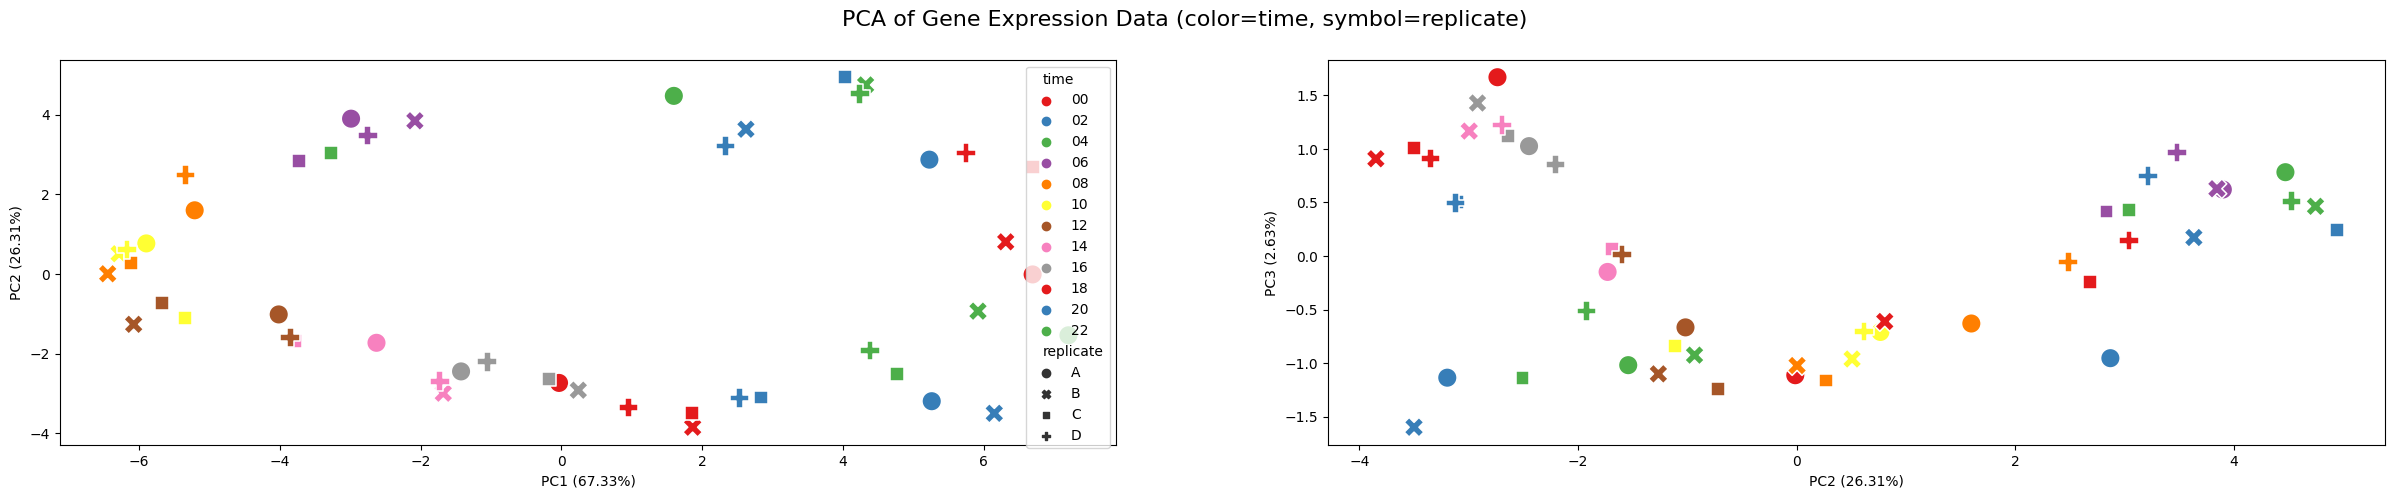

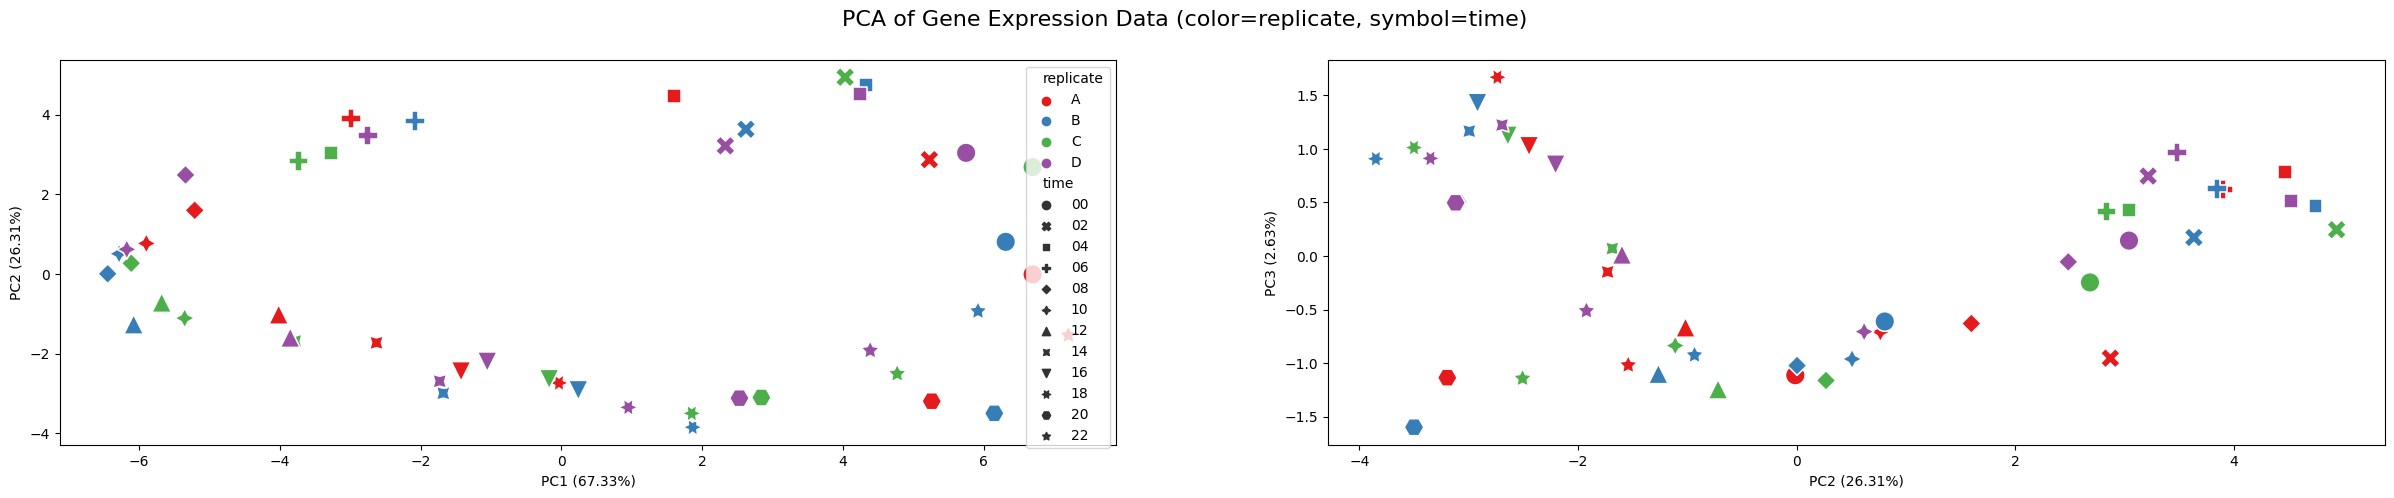

In [14]:
# Select the genes from the exon DataFrame
dat_exon_selected = dat_exon.loc[genes_mask]

# Perform the PCA on exon, plot, and return the PCA loadings. 
PC_loadings_all = run_PCA(dat_exon_selected, n_components=3, color_by='time', symbol_by='replicate', scale_data=False, log_transform=False)
run_PCA(dat_exon_selected, n_components=3, color_by='replicate', symbol_by='time', scale_data=False, log_transform=False);

The PCA results reveal a 24-hour rhythm, with a counterclockwise rotation of the time points. This pattern is evident in the PC1 vs PC2 plot, where the four replicates for each time point appear closely grouped (the most spread out is time 04, where replicate C is within the cluster of time 06).
This says that the chosen genes are following 24h rythms in the abundance of mRNA.

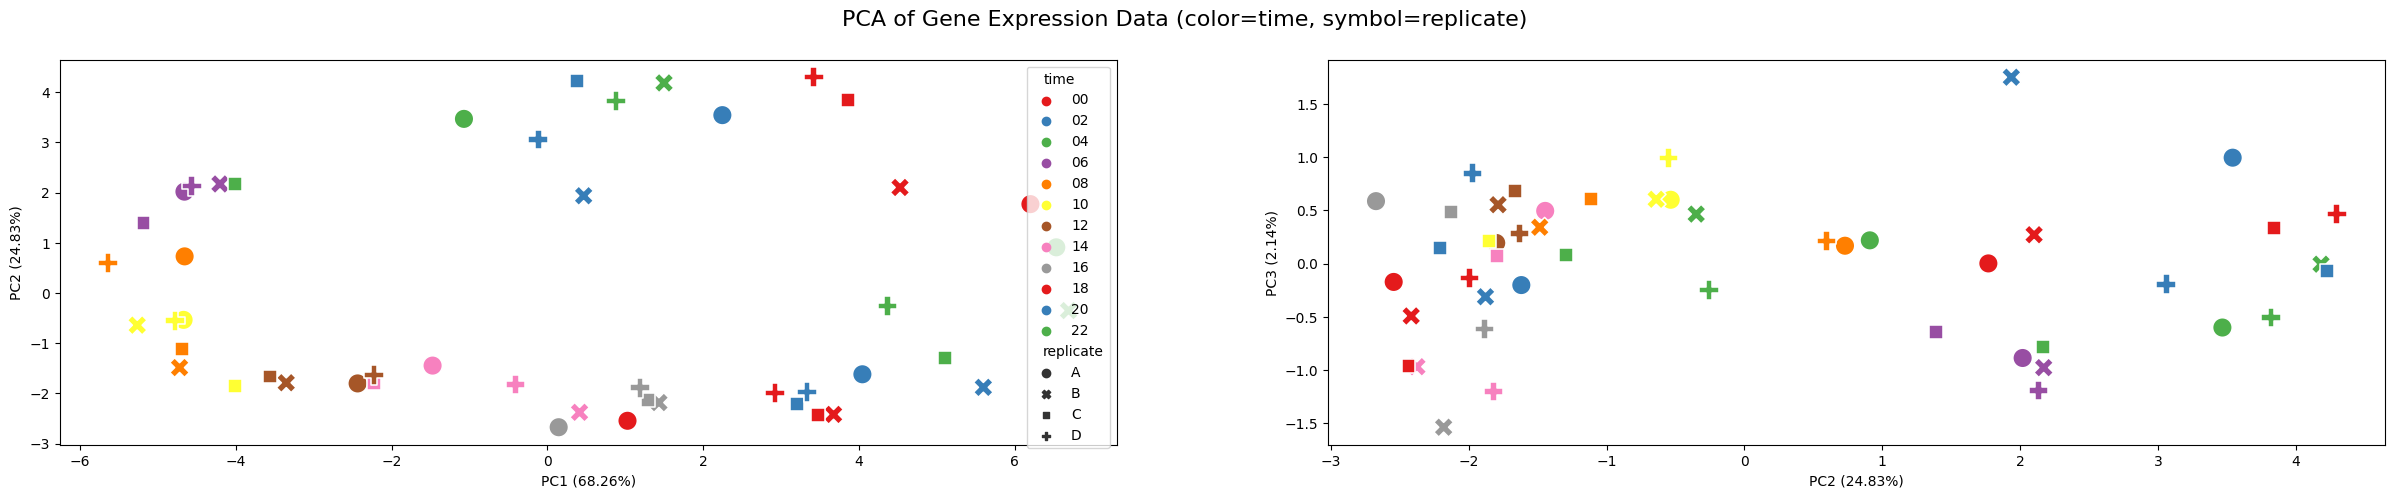

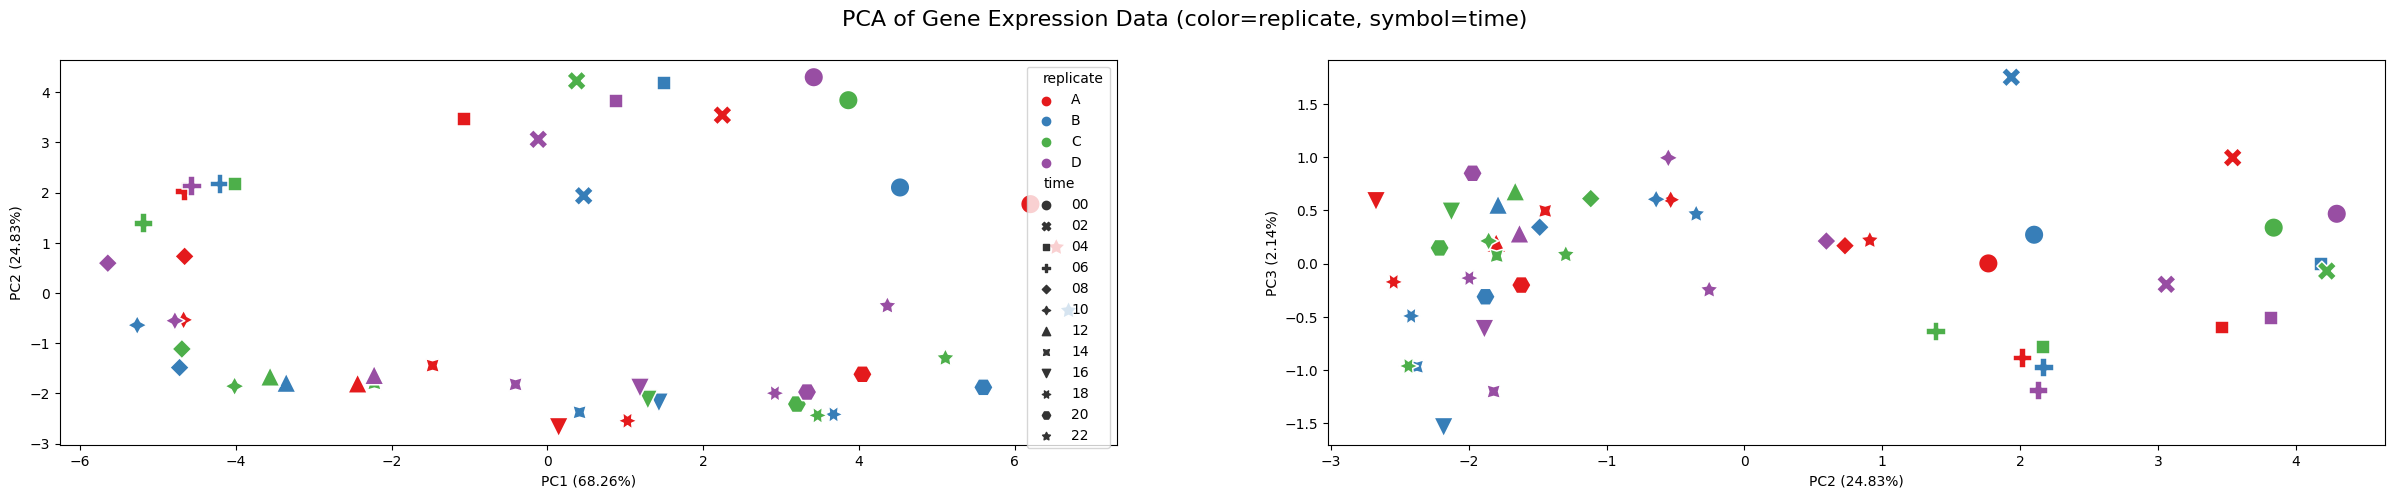

In [15]:
# Select the genes from the intron DataFrame
dat_intron_selected = dat_intron.loc[genes_mask]

# Perform the PCA on intron, plot, and return the PCA loadings. 
PC_loadings_all = run_PCA(dat_intron_selected, n_components=3, color_by='time', symbol_by='replicate', scale_data=False, log_transform=False)
run_PCA(dat_intron_selected, n_components=3, color_by='replicate', symbol_by='time', scale_data=False, log_transform=False);

The clustering of replicates of the same time point is apparent in both PC1 and PC2, maintaining a relatively close proximity (the most spread out is time 04, where replicate C is within the cluster of time 06). Furthermore, the 24h rythm and the counterclockwise rotation observed in the exons is consistently reflected in the introns analysis of PC1 vs PC2.
This says that the chosen genes are following 24h rythms in the transcription levels.

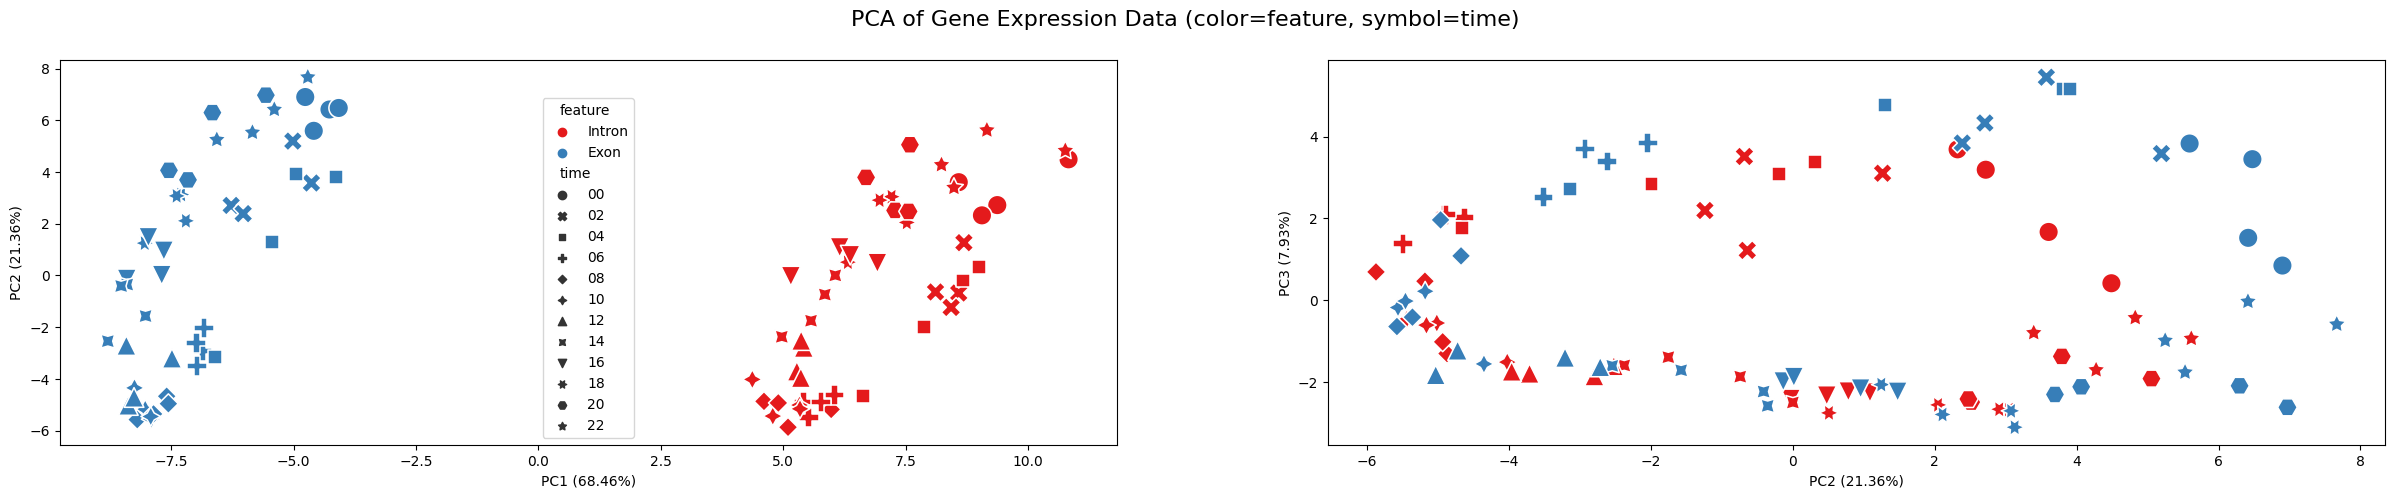

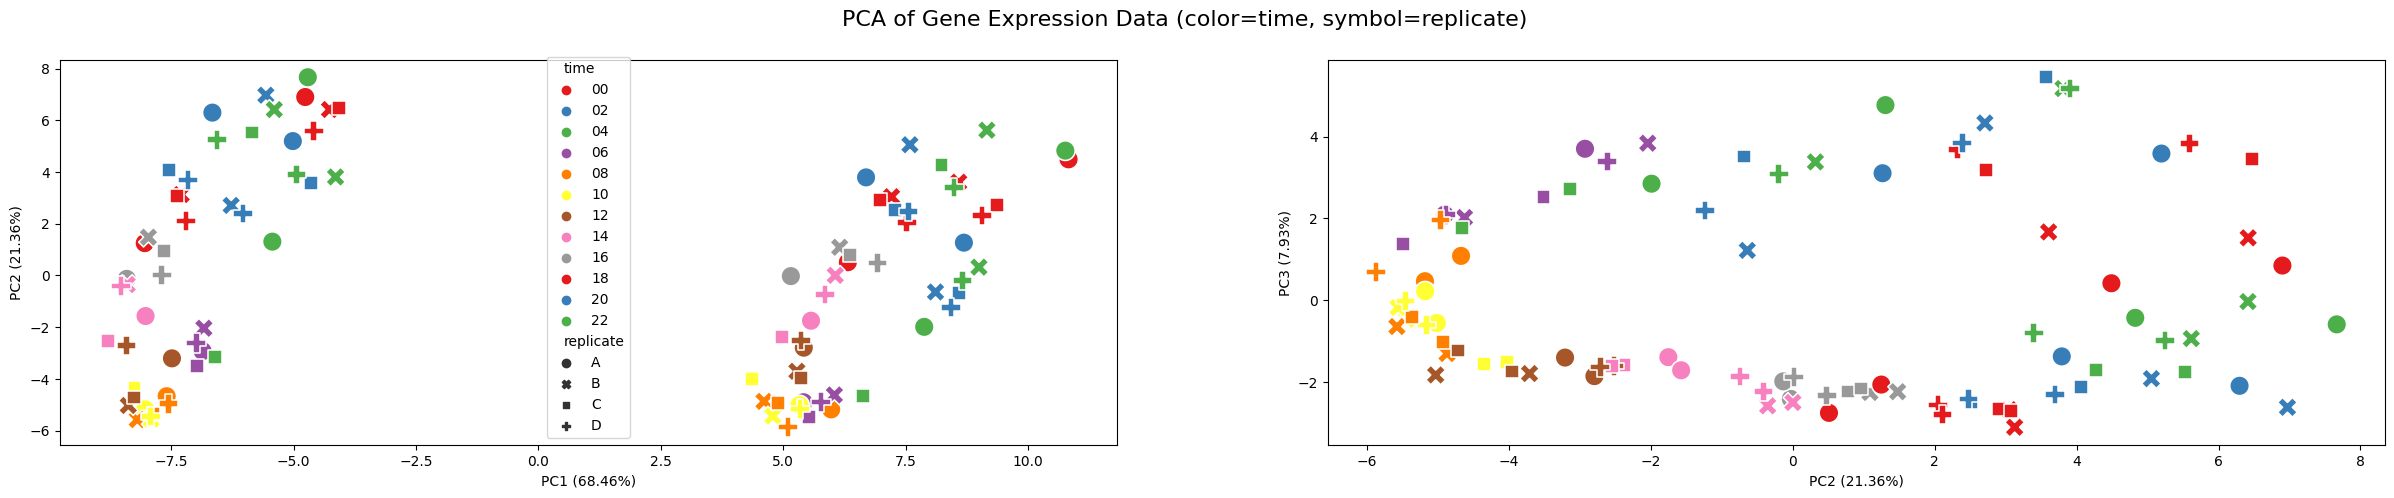

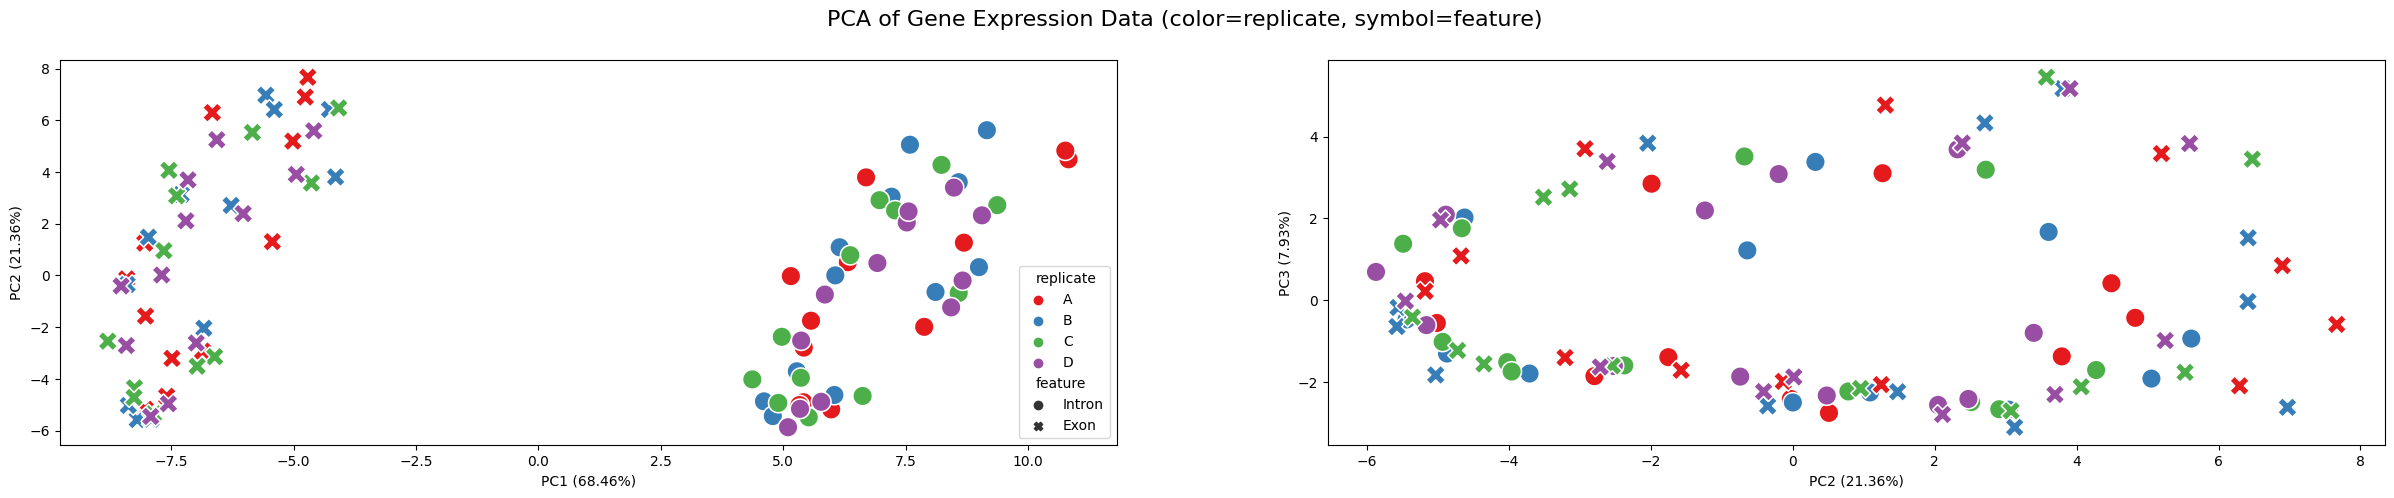

In [16]:
# Select the genes from the exon and intron DataFrame
dat_selected = dat_all.loc[genes_mask]

# Perform the PCA on both exon and intron, plot, and return the PCA loadings. 
PC_loadings_all = run_PCA(dat_selected, n_components=3, color_by='feature', symbol_by='time', scale_data=False, log_transform=False);
run_PCA(dat_selected, n_components=3, color_by='time', symbol_by='replicate', scale_data=False, log_transform=False);
run_PCA(dat_selected, n_components=3, color_by='replicate', symbol_by='feature', scale_data=False, log_transform=False);

The feature type (intron or exon) accounts for most of the variance in the data (refer to PC1). Times give a lower level of variability on PC1.
The counterclockwise rotation observed in the exons and introns is consistently reflected in the PC2 vs PC3 plot, as we would expect.

#### Question 1 part 2
2. Use the *return_amp_phase_pv* function on the $log_2$ data to assess and characterize rhythmicity genome-wide.
    * Select genes based on p-value ($p<0.01$) and amplitude (log2 fold-change>0.5) thresholds for further analysis.
    * Provide histograms of the peak times, and amplitudes ($log_2$ peak-to-trough) for the selected genes.
    * Perform this analysis separately for the exons and introns.
    * Examine whether you observe patterns typically referred to as the 'morning' and 'evening' waves of gene expression.
    
The code and the reasoning are provided below.

##### Assess rhythmicity

In [17]:
# Function to infer the p-value, phase, amplitude and mean from a time-serie y with size N, period T and sampling Ts. 
def return_amp_phase_pv(y, Ts, T, N):
    """
    Perform harmonic regression using a Fourier series to infer the amplitude, phase, p-value, and mean from a time series.

    Parameters:
    y: Time series data.
    Ts: Sampling interval.
    T: Period of the time series.
    N: Number of data points in the time series.

    Returns:
    tuple: A tuple containing amplitude, phase, p-value, and mean of the time series.

    Notes:
    - The function uses Fast Fourier Transform (FFT) to decompose the time series.
    - Harmonic regression is performed to fit a cosine wave to the data.
    - The p-value is calculated based on the fit statistics, providing an estimate of the fit quality.
    """
      
    # Time vector for the series
    t = np.linspace(0.0, N * Ts, N)

    # Fourier Transform
    x_fft = np.fft.fft(y)
    freq = np.fft.fftfreq(len(y), d=Ts)

    # Identify the frequency closest to 1/T
    index, = np.where(np.isclose(freq, 1/T, atol=0.005))

    # Calculate amplitude and phase
    amp = 4 / N * np.abs(x_fft[index[0]])
    phase = T * np.arctan2(-x_fft[index[0]].imag, x_fft[index[0]].real) / (2 * np.pi)

    # Mean of the time series
    mu = 1 / N * x_fft[0].real
    
    # Harmonic regression to compute residuals and statistics
    x_hat = mu + 0.5 * amp * np.cos(2 * np.pi / T * t - 2 * np.pi * phase / T)
    res = y - x_hat
    sig2_1 = np.var(res)
    sig2 = np.var(y)
    R2 = 1 - sig2_1 / sig2

    # Compute p-value
    p = 3
    pval = 1 - beta.cdf(R2, (p - 1) / 2, (N - p) / 2)

    # Adjust phase to be within [0, T]
    if phase < 0:
        phase += T
        
    return amp, phase, pval, mu

In [18]:
def process_data(data, feature_type, Ts, T, N):
    """
    Applies the return_amp_phase_pv function to all genes for a given feature type (intron or exon).

    Parameters:
    data: The dataset containing gene expression data.
    feature_type: Type of feature to process ('Intron' or 'Exon').
    Ts: Sampling time.
    T: Period.
    N: Number of samples.

    Returns:
    dict: A dictionary containing arrays for amplitude, phase, p-value, mean and gene name for the specified feature type.
    """

    feature_pos = data.columns.get_level_values('feature').isin([feature_type])
    results = {'amp': [], 'phase': [], 'pv': [], 'mu': [], 'gene': []}

    for _, row in data.iterrows():
        a, p, pv, mu = return_amp_phase_pv(np.array(row)[feature_pos], Ts, T, N)
        results['amp'].append(a)
        results['phase'].append(p)
        results['pv'].append(pv)
        results['mu'].append(mu)
        results['gene'].append(row.name)

    # Convert lists to numpy arrays
    for key in results:
        results[key] = np.array(results[key])

    return results


##### Plot phases and amplitudes

In [19]:
# Apply the function to both intron and exon data
Ts = 2.0
T = 24
N = 48

results_intron =  pd.DataFrame(process_data(dat, 'Intron', Ts, T, N))
results_exon = pd.DataFrame(process_data(dat, 'Exon', Ts, T, N))

# Select rhythmic genes based on p-value lower than 0.01 and amplitude greater than 0.5
introns_selected_bool = np.logical_and(results_intron['pv'] < 0.01, results_intron['amp'] > 0.5)
exons_selected_bool = np.logical_and(results_exon['pv'] < 0.01, results_exon['amp'] > 0.5)

exons_dat = results_exon[exons_selected_bool]
introns_dat = results_intron[introns_selected_bool]

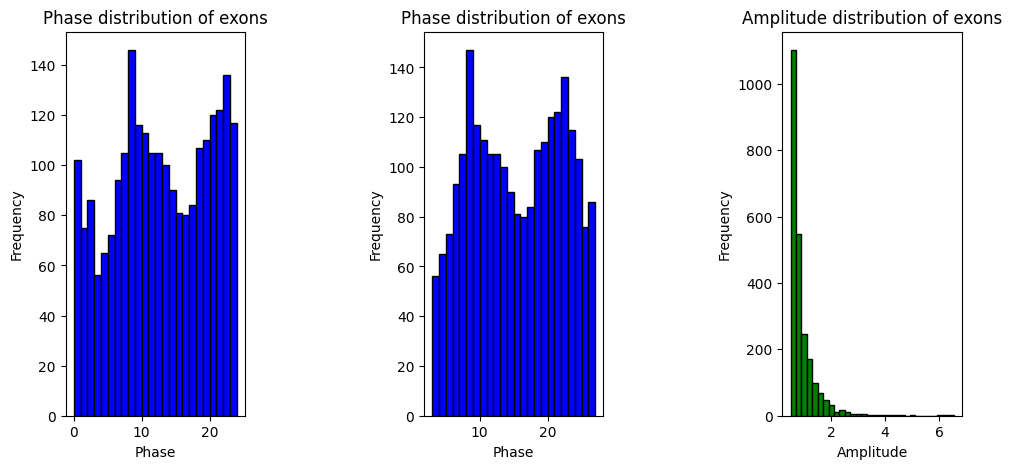

In [20]:
# Plot the phase and amplitude distributions of exons
fig1, axs1 = plt.subplots(1, 3)
fig1.subplots_adjust(left=0.1, bottom=0.1, right=1.5, top=0.9, wspace=1, hspace=0.5)

# Plot the phase distribution of exons
axs1[0].hist(exons_dat['phase'], bins=24, color='blue', edgecolor='black')
axs1[0].set_title('Phase distribution of exons')
axs1[0].set_xlabel('Phase')
axs1[0].set_ylabel('Frequency')

values = exons_dat.copy()
values = values['phase']
values[values < 3] = values + 24
# Plot the phase distribution of exons to show bimodal distribution
axs1[1].hist(values, bins=24, color='blue', edgecolor='black')
axs1[1].set_title('Phase distribution of exons')
axs1[1].set_xlabel('Phase')
axs1[1].set_ylabel('Frequency')

# Plot the amplitude distribution of exons
axs1[2].hist(exons_dat['amp'], bins=30, color='green', edgecolor='black')
axs1[2].set_title('Amplitude distribution of exons')
axs1[2].set_xlabel('Amplitude')
axs1[2].set_ylabel('Frequency')

plt.show()

Two plots for the phase distribution have been made, to show that there is a bimodal distribution.
The second plot for the phase distribution was done to show that the distribution is bimodal. For plotting this graphs, phases lower than 3h were increased by 24h.
The two peaks occur around 10am and 10pm (22). The 12-hour gap between these peaks and their values (10am and 10pm) suggests the existence of 'morning' and 'evening' waves of gene expression.

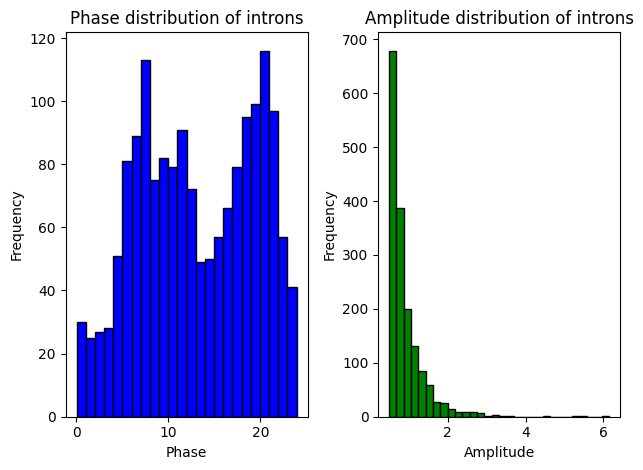

In [21]:
# Plot the phase and amplitude distributions of introns
fig1, axs1 = plt.subplots(1, 2)

# Plot the phase distribution of introns
axs1[0].hist(introns_dat['phase'], bins=24, color='blue', edgecolor='black')
axs1[0].set_title('Phase distribution of introns')
axs1[0].set_xlabel('Phase')
axs1[0].set_ylabel('Frequency')

# Plot the amplitude distribution of introns
axs1[1].hist(introns_dat['amp'], bins=30, color='green', edgecolor='black')
axs1[1].set_title('Amplitude distribution of introns')
axs1[1].set_xlabel('Amplitude')
axs1[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

The phase distribution is a bimodal distribution with two peaks that occur around 8am and 8pm (20). The 12-hour gap between these peaks and their values (8am and 8pm) suggests the existence of 'morning' and 'evening' waves of gene expression.
As we would expect from Exercise 1, the phase of the exons have a small delay compared to the phase of the introns.

Additionally, both introns and exons exhibit an amplitude distribution that follows an exponential decay. The majority of genes show low amplitude, while a smaller fraction displays high amplitude. This exponential decay pattern underscores the prevalence of genes with lower amplitudes in comparison to those with higher amplitudes.

#### Question 1 part 3
3. Determine which genes show the highest amplitude rhythmic patterns. Are there any common themes or characteristics among these genes?

In [22]:
# Selecting the threshold of the amplitude
amp_threshold_exon = 5
amp_threshold_intron = 5

# Filtering the genes
exons_ampl_selected_bool = results_exon['amp'] > amp_threshold_exon
introns_ampl_selected_bool = results_intron['amp'] > amp_threshold_intron

exons_ampl = results_exon[exons_ampl_selected_bool]
introns_ampl = results_intron[introns_ampl_selected_bool]

# Print the genes with high amplitude
print(f'The genes which exons have amplitude higher than {amp_threshold_exon} are ' + ', '.join(list(exons_ampl['gene'])))
print(f'The genes which introns have amplitude higher than {amp_threshold_intron} are ' + ', '.join(list(introns_ampl['gene'])))

The genes which exons have amplitude higher than 5 are Nr1d1, Rgs16, Mfsd2a, Gm129, Dbp
The genes which introns have amplitude higher than 5 are Nr1d1, Rgs16, Dbp


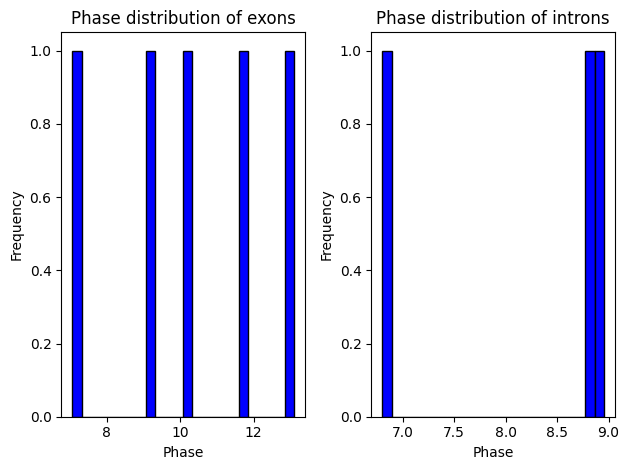

In [23]:
# Plot the phase distribution of genes with high amplitude
fig1, axs1 = plt.subplots(1, 2)

# Exons
axs1[0].hist(exons_ampl['phase'], bins=24, color='blue', edgecolor='black')
axs1[0].set_title('Phase distribution of exons')
axs1[0].set_xlabel('Phase')
axs1[0].set_ylabel('Frequency')

# Introns
axs1[1].hist(introns_ampl['phase'], bins=24, color='blue', edgecolor='black')
axs1[1].set_title('Phase distribution of introns')
axs1[1].set_xlabel('Phase')
axs1[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Maximum expression is reached at the dark–light transition.
There is a small phase delay between introns and exons.
These results can be seen also in the following plots.

##### Plot genes

In [24]:
## Plot Gene profile across all conditions
def plot_gene(data, gene):
    """
    Plots the gene expression profile across different conditions and time points.
    
    Parameters:
    data: The gene expression data.
    gene: The gene to plot.

    Returns:
    None
    """
    
    # Subselect the dataset
    time = ['00', '02', '04', '06', '08', '10', '12', '14', '16', '18', '20', '22']
    # Select introns and exons from the replicate A
    dat_AE = subselect(data, ['Exon'], ['A'], time)
    dat_AI = subselect(data, ['Intron'], ['A'], time)
    # Select introns and exons from the replicate B
    dat_BE = subselect(data, ['Exon'], ['B'], time)
    dat_BI = subselect(data, ['Intron'], ['B'], time)
    # Select introns and exons from the replicate C
    dat_CE = subselect(data, ['Exon'], ['C'], time)
    dat_CI = subselect(data, ['Intron'], ['C'], time)
    # Select introns and exons from the replicate D
    dat_DE = subselect(data, ['Exon'], ['D'], time)
    dat_DI = subselect(data, ['Intron'], ['D'], time)
    
    # Definition of time
    t = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22]

    # Plot
    fig, axs = plt.subplots(2, 2, figsize=(8,8), sharex=True)
    fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.5)
    
    # Plot replicate A
    axs[0, 0].plot(t, dat_AE[dat_AE.index.str.endswith(gene)].values.T, 'o', color = 'lightblue', label='Exon')
    axs[0, 0].plot(t, dat_AI[dat_AI.index.str.endswith(gene)].values.T, 'o', color = 'red', label='Intron')
    axs[0, 0].set_title("replicate A")
    axs[0, 0].legend()
    
    # Plot replicate B
    axs[0, 1].plot(t, dat_BE[dat_BE.index.str.endswith(gene)].values.T, 'o', color = 'lightblue', label='Exon')
    axs[0, 1].plot(t, dat_BI[dat_BI.index.str.endswith(gene)].values.T, 'o', color = 'red', label='Intron')
    axs[0, 1].set_title("replicate B")
    axs[0, 1].legend()
    
    # Plot replicate C
    axs[1, 0].plot(t, dat_CE[dat_CE.index.str.endswith(gene)].values.T, 'o', color = 'lightblue', label='Exon')
    axs[1, 0].plot(t, dat_CI[dat_CI.index.str.endswith(gene)].values.T, 'o', color = 'red', label='Intron')
    axs[1, 0].set_title("replicate C")
    axs[1, 0].legend()
    
    # Plot replicate D
    axs[1, 1].plot(t, dat_DE[dat_DE.index.str.endswith(gene)].values.T, 'o', color = 'lightblue', label='Exon')
    axs[1, 1].plot(t, dat_DI[dat_DI.index.str.endswith(gene)].values.T, 'o', color = 'red', label='Intron')
    axs[1, 1].set_title("replicate D")  
    axs[1, 1].legend()
        
    for ax in axs.flat:
        ax.set(xlabel='Time [h]', ylabel='RPKM')

    fig.suptitle(f'Gene Expression Profile for {gene}', fontsize=16)
    plt.show()

           amp     phase   pv        mu   gene
2270  6.053347  7.066686  0.0  0.991471  Nr1d1
           amp     phase            pv        mu   gene
2270  5.307494  6.803025  3.330669e-16 -1.065502  Nr1d1


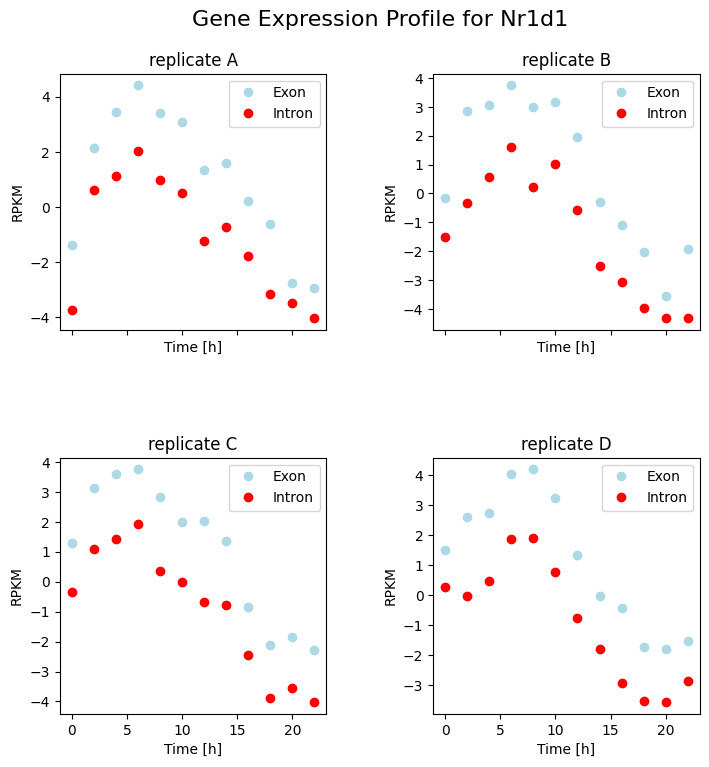

In [25]:
# Print information and plot gene Nr1d1
print(results_exon[results_exon['gene'] == "Nr1d1"])
print(results_intron[results_intron['gene'] == "Nr1d1"])
plot_gene(dat,"Nr1d1")

           amp     phase            pv        mu   gene
4458  6.538457  9.235834  1.931788e-14  0.763744  Rgs16
           amp     phase            pv        mu   gene
4458  5.474387  8.822007  1.068035e-12 -1.609643  Rgs16


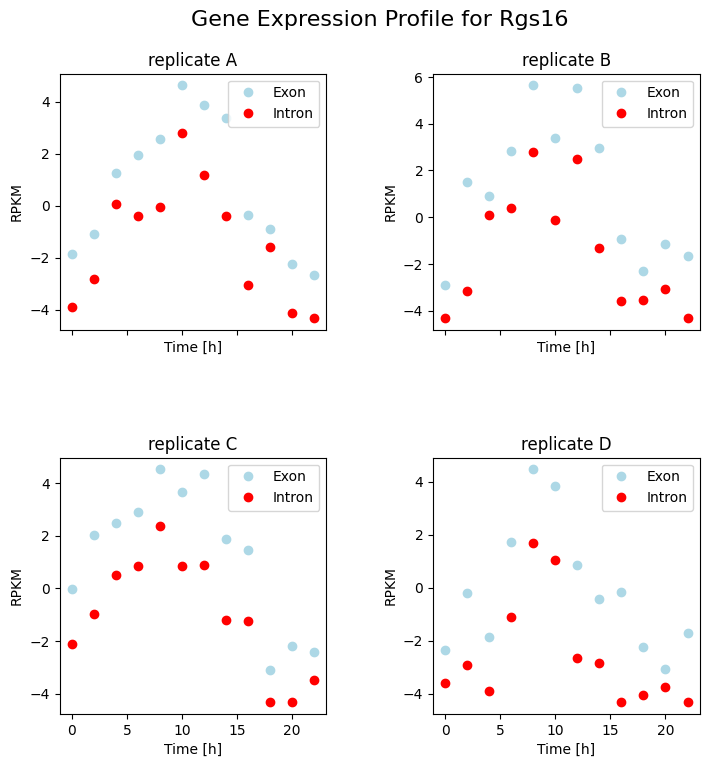

In [26]:
# Print information and plot gene Rgs16
print(results_exon[results_exon['gene'] == "Rgs16"])
print(results_intron[results_intron['gene'] == "Rgs16"])
plot_gene(dat,"Rgs16")

         amp      phase            pv        mu    gene
5450  5.0598  13.098721  2.768880e-10  1.448293  Mfsd2a
           amp     phase            pv        mu    gene
5450  3.429768  12.36821  3.009042e-09 -1.774252  Mfsd2a


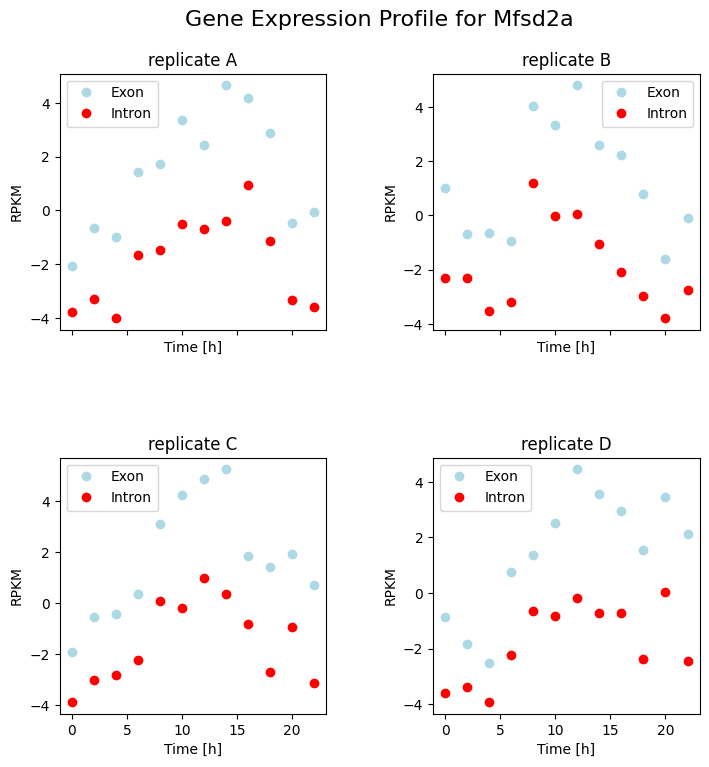

In [27]:
# Print information and plot gene Mfsd2a
print(results_exon[results_exon['gene'] == "Mfsd2a"])
print(results_intron[results_intron['gene'] == "Mfsd2a"])
plot_gene(dat,"Mfsd2a")

           amp      phase            pv        mu   gene
8807  6.210923  11.835515  2.886580e-15 -0.128229  Gm129
           amp      phase            pv        mu   gene
8807  4.606554  11.300769  8.637535e-14 -2.023504  Gm129


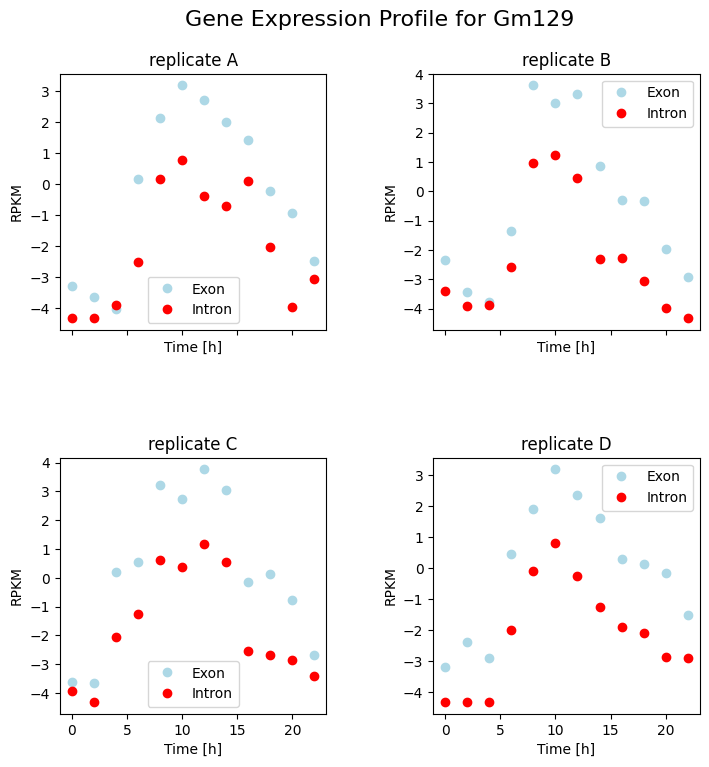

In [28]:
# Print information and plot gene Gm129
print(results_exon[results_exon['gene'] == "Gm129"])
print(results_intron[results_intron['gene'] == "Gm129"])
plot_gene(dat,"Gm129")

            amp      phase            pv        mu gene
11874  6.342534  10.154688  1.110223e-16  2.224485  Dbp
            amp     phase   pv        mu gene
11874  6.142029  8.954931  0.0 -0.404335  Dbp


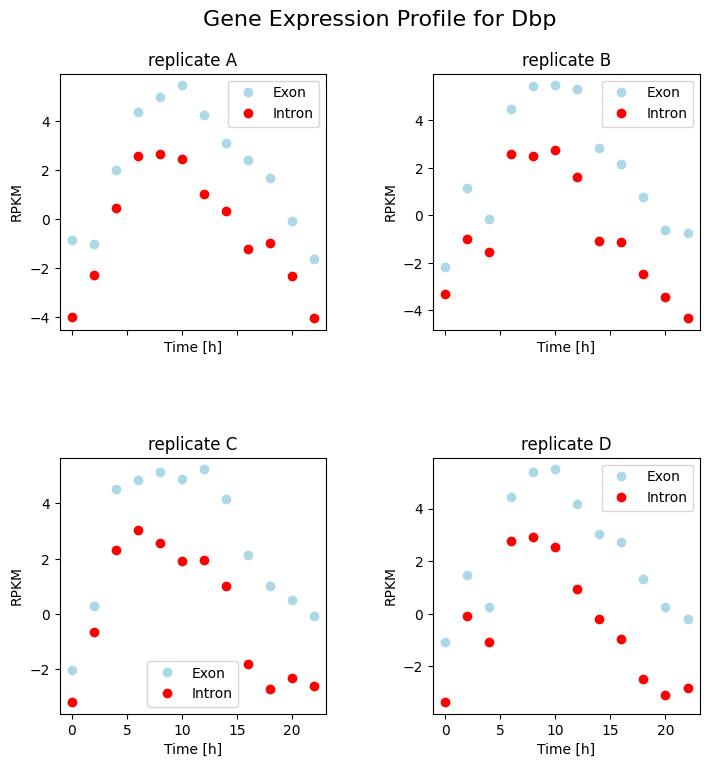

In [29]:
# Print information and plot gene Dbp
print(results_exon[results_exon['gene'] == "Dbp"])
print(results_intron[results_intron['gene'] == "Dbp"])
plot_gene(dat,"Dbp")

All these genes seem to belong to the group A of the paper (group A is composed of genes with the same rhythmic parameters for introns and exons). 
In particular, group A has short-lived mRNA. This agrees with finding in Exercise 1 of this notebook, since short half-life means high $k_0$, which means lower phase delay and higher oscillation amplitude.

##### Gene Ontology

In [30]:
# Selecting the threshold of the amplitude
amp_threshold_exon = 3

# Filtering the genes
exons_ampl_selected_bool = results_exon['amp'] > amp_threshold_exon

exons_ampl = results_exon[exons_ampl_selected_bool]

In [31]:
gene_list = list(exons_ampl['gene'])

# run the enrichment analysis
enr = gp.enrichr(gene_list=gene_list,
                 gene_sets='GO_Biological_Process_2021',
                 organism='mouse', 
                 outdir=None)
display(enr.results.head(10))

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,entrainment of circadian clock by photoperiod ...,4/27,4.523975e-08,0.000011,0,0,150.850662,2551.079226,PER2;PER1;PER3;USP2
1,GO_Biological_Process_2021,photoperiodism (GO:0009648),4/28,5.273127e-08,0.000011,0,0,144.557971,2422.510740,PER2;PER1;PER3;USP2
2,GO_Biological_Process_2021,regulation of transcription by RNA polymerase ...,13/2206,1.553257e-06,0.000213,0,0,7.528500,100.694862,EGR1;CDKN1A;USP2;NR1D2;NR1D1;NPAS2;ARNTL;PER2;...
3,GO_Biological_Process_2021,negative regulation of cellular macromolecule ...,7/547,6.078171e-06,0.000626,0,0,12.595463,151.281671,PER2;PER1;CDKN1A;NR1D2;TRIB3;NR1D1;ARNTL
4,GO_Biological_Process_2021,phosphatidylcholine biosynthetic process (GO:0...,3/33,1.165118e-05,0.000960,0,0,83.095833,943.977200,CHKA;LPIN1;MFSD2A
5,GO_Biological_Process_2021,regulation of circadian sleep/wake cycle (GO:0...,2/5,1.750603e-05,0.001058,0,0,532.533333,5832.818995,PER3;NR1D1
6,GO_Biological_Process_2021,positive regulation of transcription by RNA po...,8/908,1.796888e-05,0.001058,0,0,8.923041,97.500900,EGR1;PER1;DBP;NR1D2;NR1D1;LPIN1;NPAS2;ARNTL
7,GO_Biological_Process_2021,"negative regulation of transcription, DNA-temp...",8/948,2.453156e-05,0.001081,0,0,8.525420,90.502021,PER2;PER1;PER3;USP2;NR1D2;TRIB3;NR1D1;ARNTL
8,GO_Biological_Process_2021,negative regulation of transcription by RNA po...,7/684,2.591619e-05,0.001081,0,0,9.975775,105.350600,PER2;PER1;PER3;USP2;NR1D2;TRIB3;NR1D1
9,GO_Biological_Process_2021,negative regulation of glucocorticoid receptor...,2/6,2.623728e-05,0.001081,0,0,399.380000,4212.791809,PER1;ARNTL


The outcomes derived from gene ontology enrichment analysis indicate that the terms characterized by the lowest p-values include "Circadian clock," "Circadian cycle," and "Regulation." This suggests that these specific biological processes or functions are statistically significant in the context of the analyzed gene set (genes with high amplitude).

These discoveries are consistent with our prior findings, specifically in relation to Group A. Notably, the gene ontology analysis on Group A in the referenced paper yielded outcomes corresponding to "GO:0006357~regulation of transcription from RNA polymerase II promoter," encompassing both positive and negative regulation. These outcomes align with our identified terms, suggesting that genes exhibiting higher amplitude belong to Group A, indicating a lower phase delay. This alignment supports the observations made in Exercise 1, where a lower phase delay was associated with a shorter half-life, leading to higher oscillation.

### Question 2

#### Question 2 part 1
1. Related to Exercise 1, study the phase relationship between the pre-mRNA and mRNA for genes that exhibit rhythmic behavior at both the pre-mRNA and mRNA levels. Use appropriate cutoffs in your analysis to select a subset of genes that are rhythmic at both the pre-mRNA and mRNA levels. Aim to include several hundred genes for a robust analysis. 

We are considering a total of 594 genes


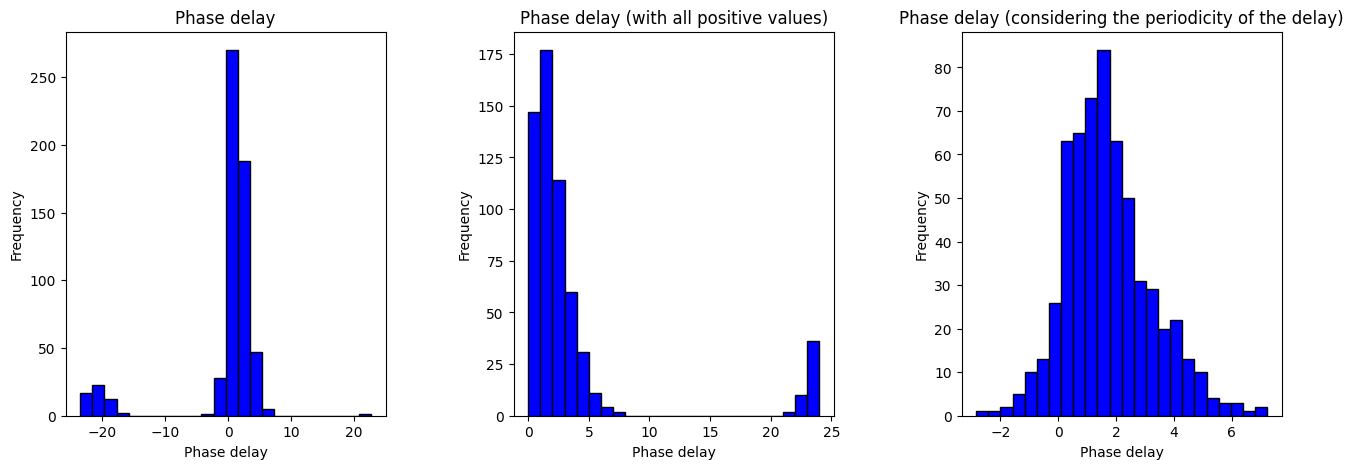

In [32]:
# Select rhythmic genes based on p-value lower than 0.01 and amplitude
selected_bool_2 = np.logical_and(results_exon['pv'] < 0.01, results_exon['amp'] > 0.7)
selected_bool_1 = np.logical_and(results_intron['pv'] < 0.01, results_intron['amp'] > 0.7)
selected_bool = np.logical_and(selected_bool_1, selected_bool_2)

exons_dat = results_exon[selected_bool]
introns_dat = results_intron[selected_bool]

# Print number of selected genes
print(f'We are considering a total of {exons_dat.shape[0]} genes')

# Compute the phase delay
phase_delay = exons_dat['phase'] - introns_dat['phase']

# Plot the phase difference
fig1, axs1 = plt.subplots(1, 3)
fig1.subplots_adjust(left=0.1, bottom=0.1, right=2, top=0.9, wspace=0.4, hspace=0.5)

# Plot the phase distribution of phase delay
axs1[0].hist(phase_delay, bins=24, color='blue', edgecolor='black')
axs1[0].set_title('Phase delay')
axs1[0].set_xlabel('Phase delay')
axs1[0].set_ylabel('Frequency')

# Compute the phase different, in order to have everything non negative
phase_delay[exons_dat['phase'] < introns_dat['phase']] = exons_dat['phase'] - introns_dat['phase'] + 24
# Plot the phase distribution of phase delay
axs1[1].hist(phase_delay, bins=24, color='blue', edgecolor='black')
axs1[1].set_title('Phase delay (with all positive values)')
axs1[1].set_xlabel('Phase delay')
axs1[1].set_ylabel('Frequency')

# Compute the phase different, in order to consider the periodicity of the delay
phase_delay[phase_delay > 12] = phase_delay[phase_delay > 12] - 24
# Plot the phase distribution of phase delay
axs1[2].hist(phase_delay, bins=24, color='blue', edgecolor='black')
axs1[2].set_title('Phase delay (considering the periodicity of the delay)')
axs1[2].set_xlabel('Phase delay')
axs1[2].set_ylabel('Frequency')

plt.show()

From this visual representation, it is evident that the maximum phase delay occurs around 6. These observations are consistent with the results from Exercise 1, where it was noted that the maximum phase delay is 6 hours (equivalent to $\frac{\pi}{2}$ radians). This aligns with scenarios where the degradation of mRNA is constant and not rhythmic.

It is reasonable to assume that phase delays lower than zero (third plot) may be due to anomalies or variance in the data, since we do not expect to have a peak in the mRNA 2 hours before the peak in the pre-mRNA.

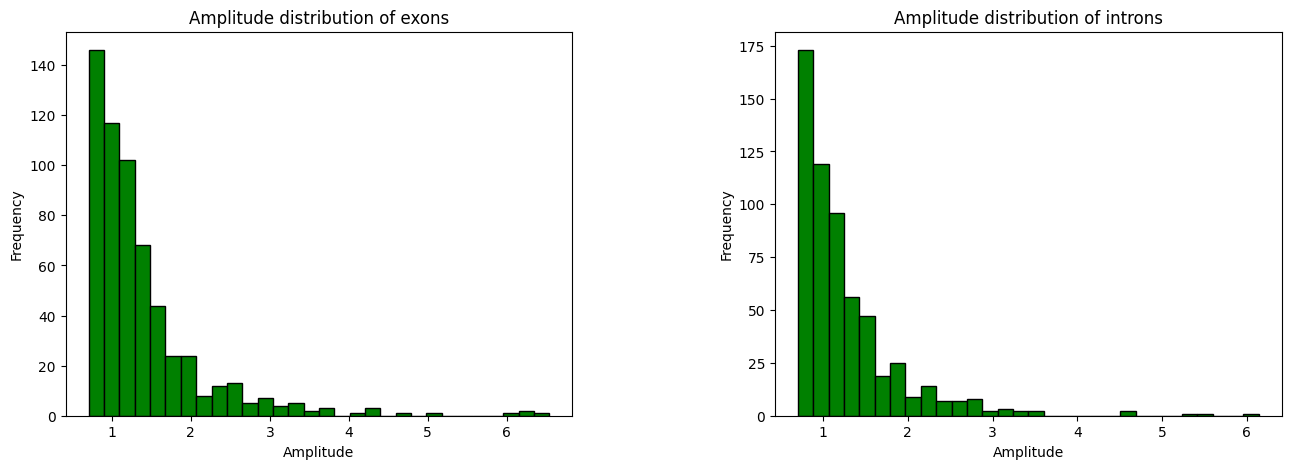

In [33]:
fig1, axs1 = plt.subplots(1, 2)
fig1.subplots_adjust(left=0.1, bottom=0.1, right=2, top=0.9, wspace=0.4, hspace=0.5)

# Plot the amplitude distribution of exons
axs1[0].hist(exons_dat['amp'], bins=30, color='green', edgecolor='black')
axs1[0].set_title('Amplitude distribution of exons')
axs1[0].set_xlabel('Amplitude')
axs1[0].set_ylabel('Frequency')

# Plot the amplitude distribution of introns
axs1[1].hist(introns_dat['amp'], bins=30, color='green', edgecolor='black')
axs1[1].set_title('Amplitude distribution of introns')
axs1[1].set_xlabel('Amplitude')
axs1[1].set_ylabel('Frequency')

plt.show()

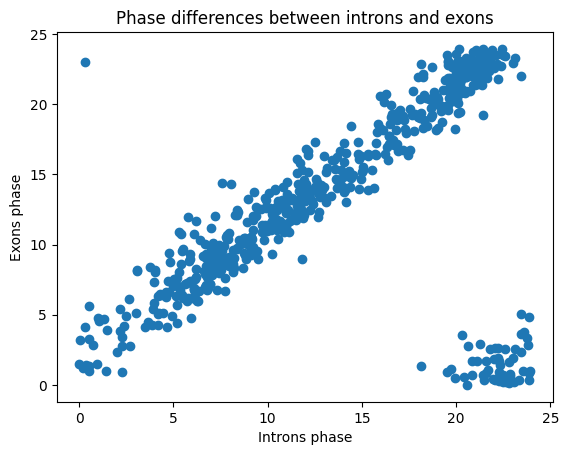

In [34]:
# Plot the phase of exons against phase of introns
plt.scatter(introns_dat['phase'], exons_dat['phase'])
plt.title('Phase differences between introns and exons')
plt.ylabel("Exons phase")
plt.xlabel("Introns phase")
plt.show()

Most of the genes have the same phase for introns and exons (and so a phase delay of 0), as it was shown also in the histogram.
The area with introns phase of 20-24 and exons phase close to zero is the continuation of the diagonal, considering that the phase are 24h periodic, so it restarts.
This aligns with the findings in Exercise 1, where the mRNAs that oscillates more are the ones with a lower phase delay.

#### Question 2 part 2
2. Show representative profiles of genes with short or large delays.  

In [35]:
# Recompute phase delay
phase_delay = exons_dat['phase'] - introns_dat['phase']
# Considering the periodicity, make all of them positive
phase_delay[exons_dat['phase'] < introns_dat['phase']] = exons_dat['phase'] - introns_dat['phase'] + 24

# Cut the values with a large phase delay, because possibly outliers 
# (removing genes where the phase delay is negative, for previous considerations)
phase_values = phase_delay[phase_delay < 10]

# Sort phase delay
sorted_phase_delay = phase_values.sort_values()

##### Genes with low phase delay

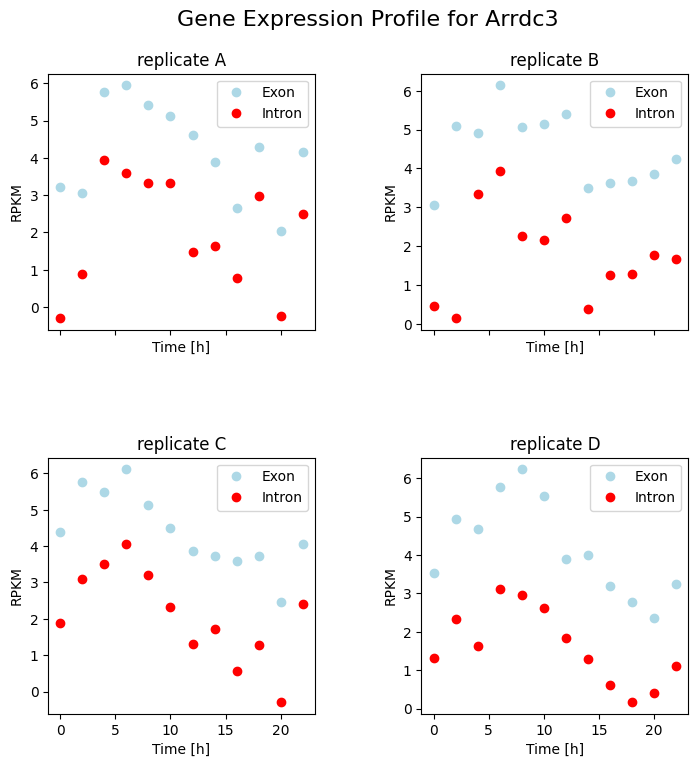

In [36]:
# Plot gene with lowest phase delay
plot_gene(dat,exons_dat.loc[sorted_phase_delay.index[0]]['gene'])

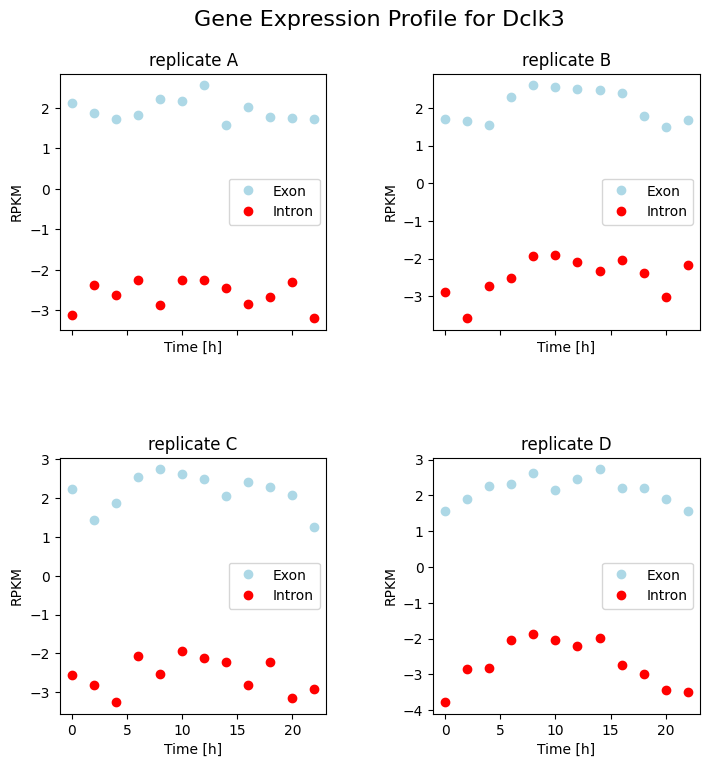

In [37]:
# Plot gene with second lowest phase delay
plot_gene(dat,exons_dat.loc[sorted_phase_delay.index[1]]['gene'])

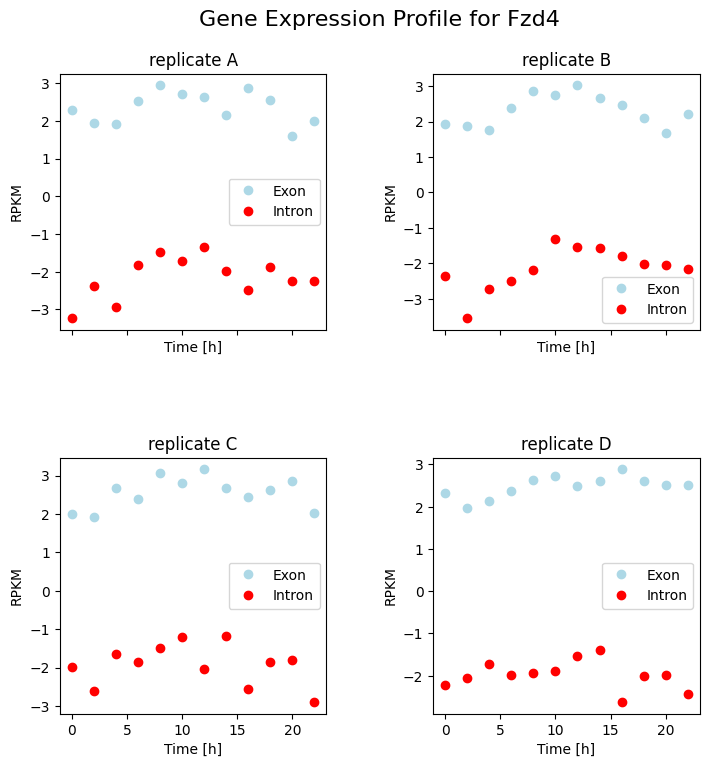

In [38]:
# Plot gene with third lowest phase delay
plot_gene(dat,exons_dat.loc[sorted_phase_delay.index[2]]['gene'])

##### Genes with high phase delay 

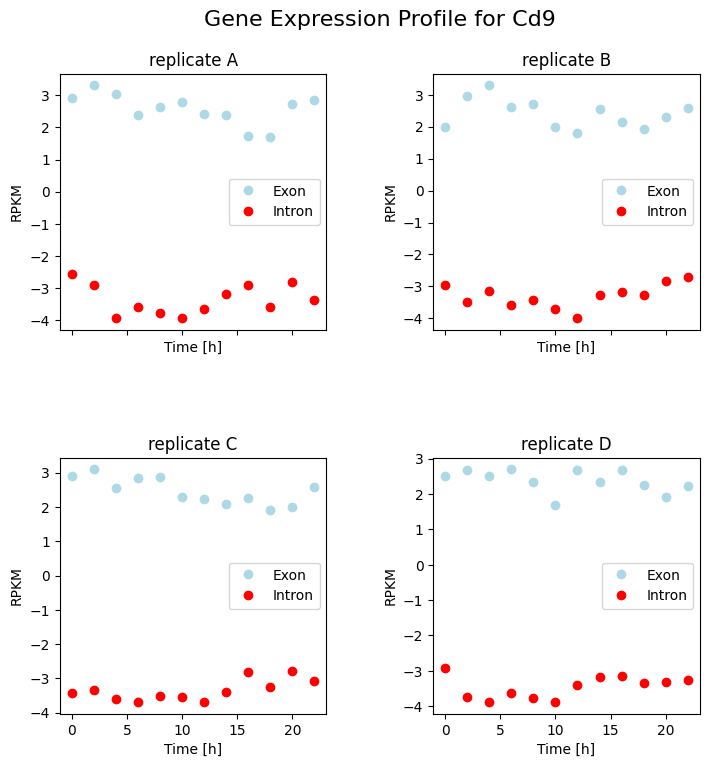

In [39]:
# Plot gene with highest phase delay
plot_gene(dat,exons_dat.loc[sorted_phase_delay.index[-1]]['gene'])

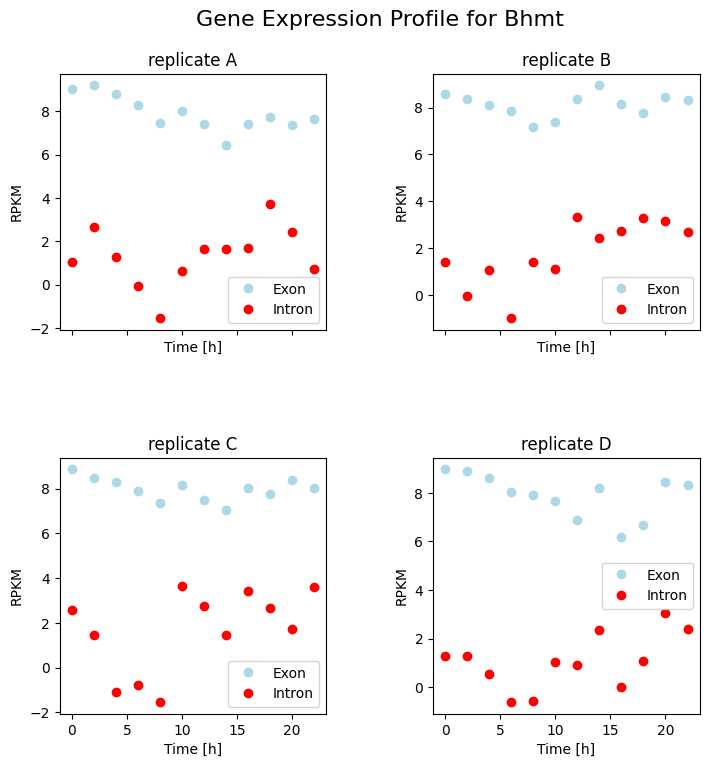

In [40]:
# Plot gene with the second highest phase delay
plot_gene(dat,exons_dat.loc[sorted_phase_delay.index[-2]]['gene'])

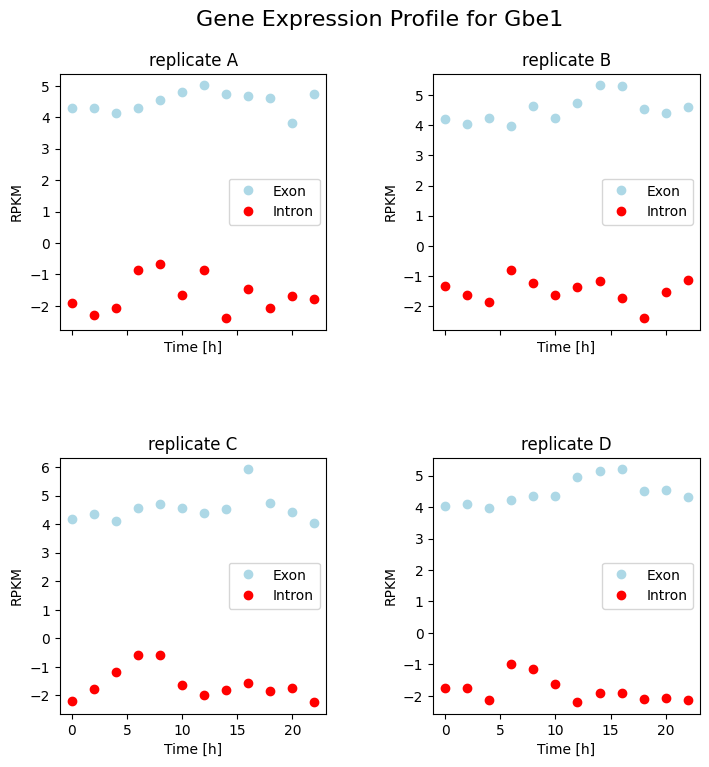

In [41]:
# Plot gene with the second highest phase delay
plot_gene(dat,exons_dat.loc[sorted_phase_delay.index[-3]]['gene'])

These graphs of the representative align with our earlier findings. Specifically, in accordance with the results from Exercise 1 and the insights from the referenced paper, a correlation persists, revealing that genes characterized by a higher phase delay typically exhibit reduced mRNA amplitudes compared to pre-mRNA amplitudes. Conversely, for genes with a low phase delay, the oscillations between introns and exons tend to be more similar.

#### Question 2 part 3
3. Investigate (e.g. use a scatter plot) the relation between the phase difference between pre-mRNA and mRNA and the amplitude ratio (log2 fold change) of pre-mRNA and mRNA.
    * Discuss the plot? E.g. Mark some outliers with their gene names. *Hint*: Identify genes that show exceptionally large/small phase differences or amplitude ratios compared to the general trend. 

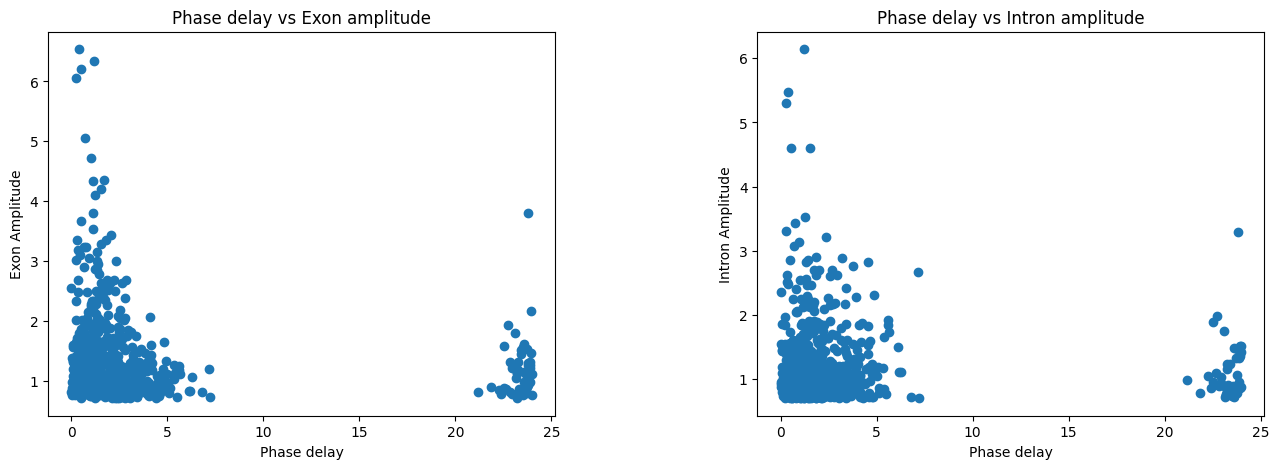

In [42]:
# Plot the relationship between phase delay and amplitude
fig1, axs1 = plt.subplots(1, 2)
fig1.subplots_adjust(left=0.1, bottom=0.1, right=2, top=0.9, wspace=0.4, hspace=0.5)

# Plot the Phase delay against the Intron amplitude
axs1[0].scatter(phase_delay, exons_dat['amp'])
axs1[0].set_title('Phase delay vs Exon amplitude')
axs1[0].set_xlabel('Phase delay')
axs1[0].set_ylabel('Exon Amplitude')

# Plot the Phase delay against the Intron amplitude
axs1[1].scatter(phase_delay, introns_dat['amp'])
axs1[1].set_title('Phase delay vs Intron amplitude')
axs1[1].set_xlabel('Phase delay')
axs1[1].set_ylabel('Intron Amplitude')

plt.show()

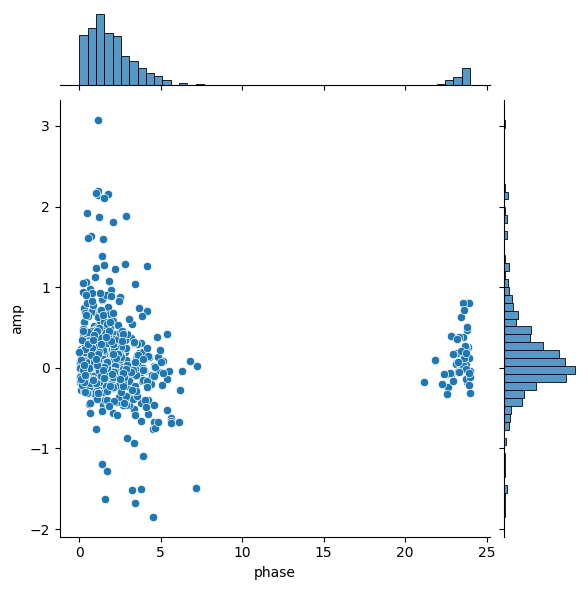

In [43]:
import seaborn as sns

# Find the ratio between the amplitudes
ratio = exons_dat['amp'] - introns_dat['amp']

sns.jointplot(x=phase_delay, y=ratio, kind='scatter')
plt.show()

As expected, the correlation remains consistent: as the phase delay increases, there is a reduction in the amplitude ratio between exons and introns.

##### Genes with high ratio

In [44]:
# Find the genes with the highest ratio
exons_dat[ratio > 3]['gene']

5724    Slc34a2
Name: gene, dtype: object

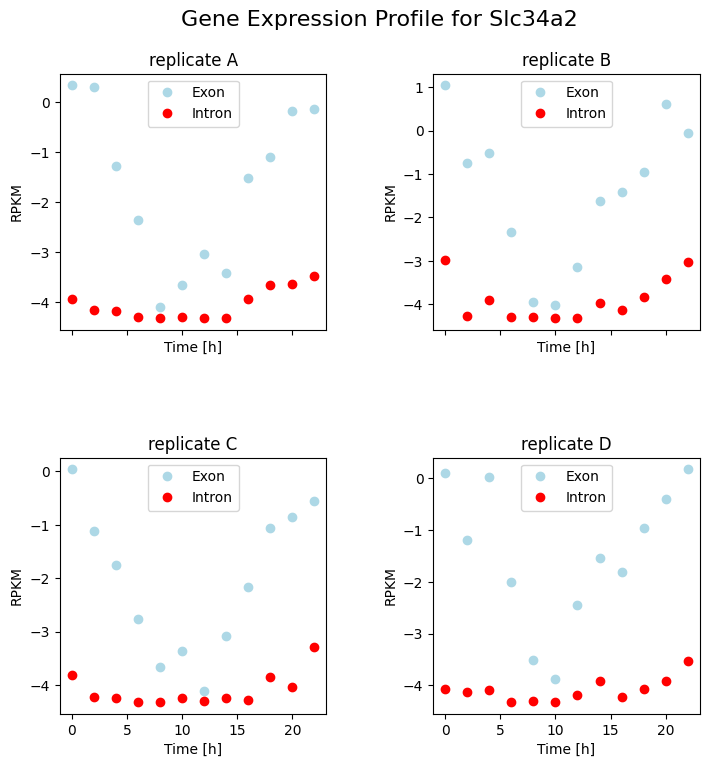

In [45]:
# Plot gene with highest ratio
plot_gene(dat,'Slc34a2')

##### Genes with low ratio

In [46]:
# Find the genes with the highest ratio
exons_dat[ratio < -1.7]['gene']

11608    Ces1d
Name: gene, dtype: object

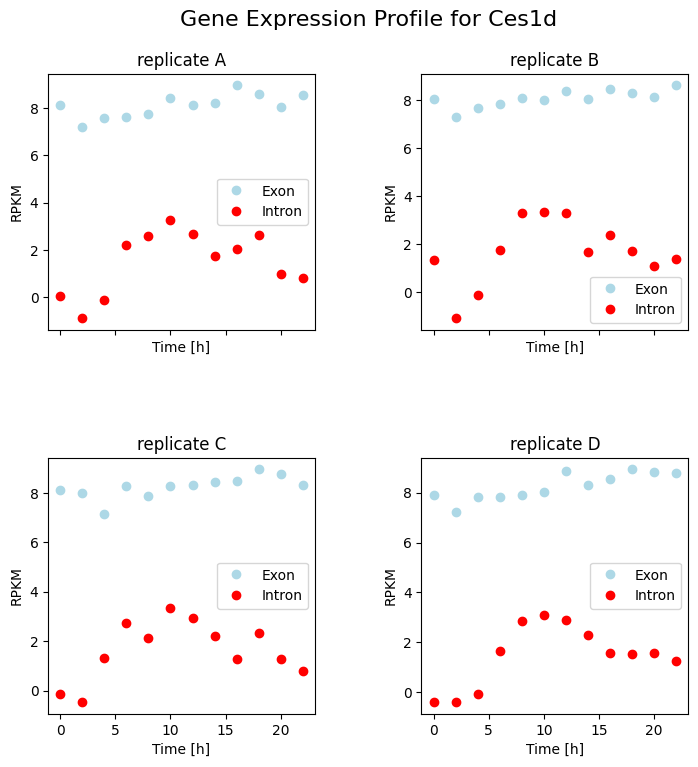

In [47]:
# Plot gene with highest ratio
plot_gene(dat,'Ces1d')

This analysis of genes with high amplitude ration and low amplitude ration shows that the genes with a lower phase delay are oscillating more than the genes with a higher phase delay.

The genes with high or low phase delay were identified previously in Question 2 part 2.

#### Analysis of genes with possible rythmic degradation (extra)

In [48]:
# Select rhythmic genes based on p-value lower than 0.01
selected_bool_2 = np.logical_and(results_exon['pv'] < 0.01, results_exon['amp'] > 0.5) 
selected_bool_1 = np.logical_and(results_intron['pv'] < 0.01, results_intron['amp'] < 0.1) 
selected_bool = np.logical_and(selected_bool_1, selected_bool_2)

exons_dat = results_exon[selected_bool]
introns_dat = results_intron[selected_bool]

# Find the ratio between the amplitudes
ratio = exons_dat['amp'] - introns_dat['amp']

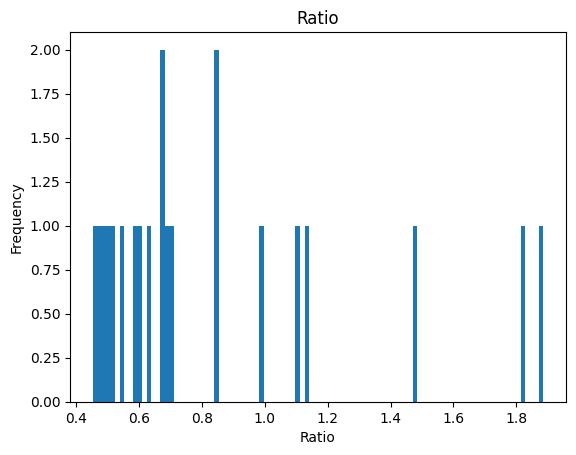

In [49]:
# Plot the ratio
plt.hist(ratio, bins=100)
plt.title('Ratio')
plt.xlabel('Ratio')
plt.ylabel('Frequency')

plt.show()

In [50]:
# Find the genes with the highest ratio
exons_dat[ratio > 1.4]['gene']

2584      Hapln1
9413      Nlrp4a
12361    Cyp2b19
Name: gene, dtype: object

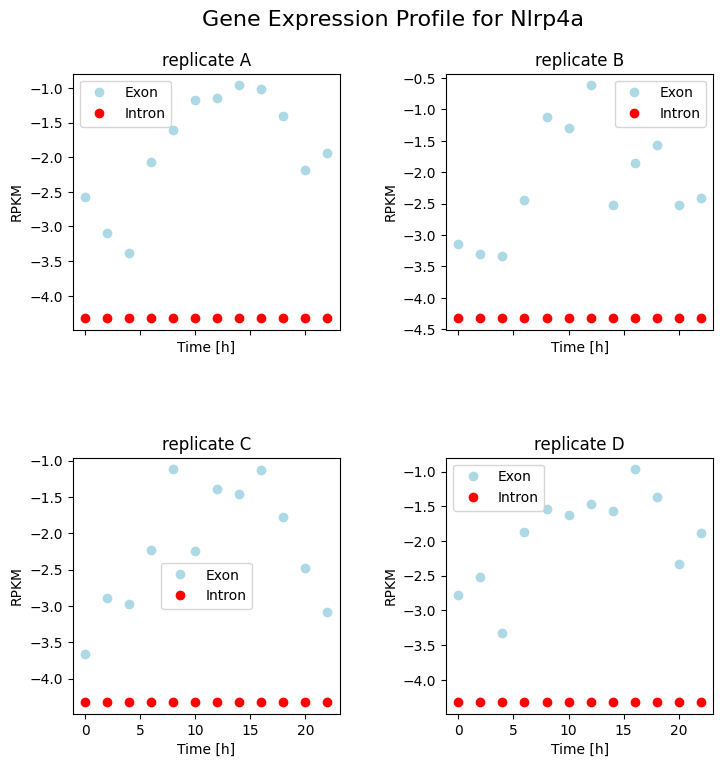

In [51]:
# Plot gene with highest ratio
plot_gene(dat,'Nlrp4a')

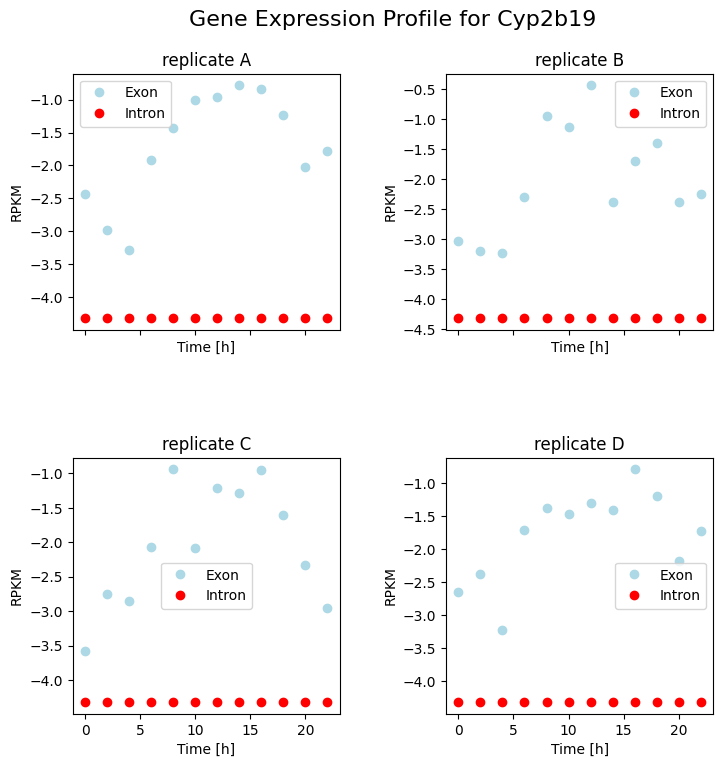

In [52]:
# Plot gene with highest ration
plot_gene(dat,'Cyp2b19')

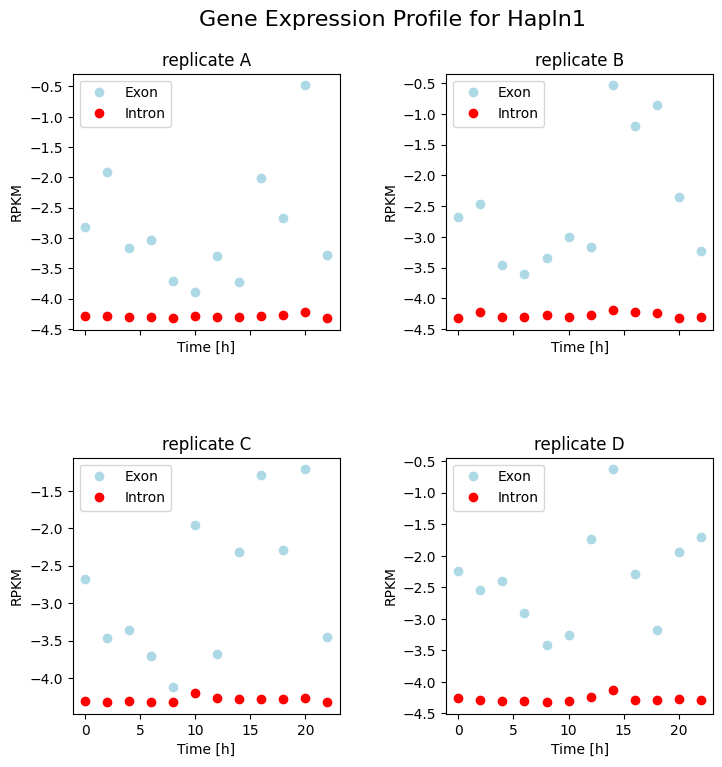

In [53]:
# Plot gene with highest ration
plot_gene(dat,'Hapln1')

The pre-mRNA exhibits no or almost no oscillations, whereas the exons display pronounced oscillations. 
This suggests rhythmic degradation.